#**Import Libraries**

In [1]:
# Google Drive
from google.colab import drive
# General
import math
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
import itertools
import random as python_random
# Keras Library
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPool2D
from keras.models import Model
from keras import backend as Kbackend
from keras.preprocessing import image
# ScikitLearn
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
# Others
import time
import datetime
import os

print("Keras version: ", keras.__version__)
print("TensorFlow version:", tf.__version__)

Keras version:  3.5.0
TensorFlow version: 2.17.1


In [ ]:
# Check GPU. With Colab Pro you have priority access to our fastest GPUs. For example, you may get a T4 or P100 GPU at times when most users of standard Colab receive a slower K80 GPU. You can see what GPU you've been assigned at any time by executing the following cell.
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)
# In order to use a GPU with your notebook, select the Runtime > Change runtime type menu, and then set the hardware accelerator dropdown to GPU.

Sat Nov 16 13:44:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# **Initialize Functions**

# Tools

In [2]:
############################
# Get no. of images
############################
def get_freq_data(generator):
  class_data_labels = generator.classes
  total_class = len(IMAGE_CLASSES)
  freq_out = []

  for i in range(total_class):
    total_label_i = 0
    for ele in class_data_labels:
      if ele == i:
        total_label_i += 1
    freq_out.append(total_label_i)

  print("Total number of class is:", total_class, generator.class_indices)
  print("Total image in generator is: ", freq_out)
  return freq_out
############################
# Display training and validation curve
############################
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('Model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['Training', 'Validation'])

############################
# Display confusion matrix
############################
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, subplot = 121):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """


    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        cm = np.round(cm,2)
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.subplot(subplot)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))  # Count number of classes for x & y axis lable
    plt.xticks(tick_marks, classes, rotation=45) # x-axis label rotated 45 degree
    plt.yticks(tick_marks, classes) # y-axis label

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

############################
# Show generated image
############################
def show_image_generated(generator, index, img_size):
  x, y = generator.__getitem__(index)
  img_plt = math.ceil(math.sqrt(BATCH_SIZE))
  grid_plt = str(img_plt)+str(img_plt)+str(1)
  plt.figure(1, figsize = (img_size,img_size))
  for i in range(BATCH_SIZE):
    plt.subplot(img_plt,img_plt,i+1)
    plt.imshow(x[i])
    plt.title(IMAGE_CLASSES[np.where(y[i] == 1.)[0][0]], fontsize = 2+img_size, pad = 0)
    plt.axis('off')
  plt.show()

###########################
# Show augmented image
###########################
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plot_augmented_images(img_generator, num, index_i = 0, index_j = 0):
    images_arr = [img_generator[index_i][0][index_j] for i in range(num)]
    fig, axes = plt.subplots(1, num, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.axis('off')
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

############################
# Show all prediction images
############################
def show_all_prediction_image(class_dir, generator, true_labels, pred_labels):
  image_freq = get_freq_data(generator)
  correct_pred = []
  wrong_pred = []
  for i in range(len(IMAGE_CLASSES)):
    correct_num = 0
    wrong_num = 0
    for j in range(len(true_labels)):
      if true_labels[j] == i:
        if true_labels[j] == pred_labels[j]:
          correct_num += 1
        else:
          wrong_num += 1
    correct_pred.append(correct_num)
    wrong_pred.append(wrong_num)

  print('Folder names:' + str(sorted(os.listdir(class_dir))))
  print('Correctly predicted:',correct_pred)
  print('Wrongly predicted:',wrong_pred)

  label_index_show = 0
  file_name = []



  disp_col = 8
  for i, class_f in enumerate(sorted(os.listdir(class_dir))):
    img_dir = class_dir + '/' + class_f
    display_row = math.ceil(image_freq[i]/disp_col)
    batch_holder = np.zeros((image_freq[i], IMAGE_WIDTH, IMAGE_HEIGHT, 3))
    print('========================================================================')
    print('True Class:', class_f)
    print('Total images:', image_freq[i],'| Correctly predicted:',correct_pred[i],'| Wrongly predicted:',wrong_pred[i])
    print('========================================================================')
    for j,img in enumerate(sorted(os.listdir(img_dir))):
      file_name.append(img)
      img = image.load_img(os.path.join(img_dir,img), target_size=(IMAGE_WIDTH,IMAGE_HEIGHT))
      batch_holder[j, :] = img

    plt.figure(1, figsize = (disp_col*1.9,display_row*2.2))

    for j,img in enumerate(batch_holder):
      title = str(file_name[label_index_show]) + '\nP: ' + IMAGE_CLASSES[pred_labels[label_index_show]]
      plt.subplot(display_row, disp_col, j+1)
      if true_labels[label_index_show] == pred_labels[label_index_show]:
        plt.title(title)
      else:
        plt.title(title,color = 'red')
      plt.axis('off')
      plt.imshow(img/256.)
      label_index_show += 1

    plt.show()

############################
# Get input image for pre-trained model
############################
def get_pretrained_model_input_size(MODEL = 'None'):
  if MODEL == 'Xception' or MODEL == 'InceptionV3' or MODEL == 'InceptionResNetV2':
    return (299, 299, 3)
  elif MODEL == 'VGG16' or MODEL == 'VGG19' or MODEL == 'ResNet50V2' or MODEL == 'ResNet101V2' or MODEL == 'ResNet152V2' or MODEL == 'MobileNetV2' or MODEL == 'DenseNet121' or MODEL == 'DenseNet169' or MODEL == 'DenseNet201' or MODEL == 'NASNetMobile':
    return (224, 224, 3)
  elif MODEL == 'NASNetLarge':
    return (331, 331, 3)
  else:
    print("Invalid model name/ not defined")
    return (0,0,0)
############################
# Convert File size unit
############################
def convert_file_size_unit(size_in_bytes, unit):
   if unit == 'kB':
       return size_in_bytes/1024
   elif unit == 'MB':
       return size_in_bytes/(1024*1024)
   elif unit == 'GB':
       return size_in_bytes/(1024*1024*1024)
   else:
       return size_in_bytes

# Data Augmentation

In [3]:
############################
# Training data generator
############################
def get_train_generator():
  print("Getting train generator...")
  image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range = 90,
      vertical_flip = True,
      horizontal_flip = True,
      fill_mode = 'reflect'
  )

  generator = image_generator.flow_from_directory(
      batch_size = BATCH_SIZE,
      directory = train_path,
      shuffle = True,             # Shuffle input after each epoch
      target_size = (IMAGE_WIDTH, IMAGE_HEIGHT),   # Set image size to be [x]px by [y]px set in IMAGE_SIZE
      class_mode = 'categorical',
      seed = SEED,
  )

  return generator
############################
# Validation data generator
############################
def get_valid_generator():
  print("Getting valid generator...")
  image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255
  )

  generator = image_generator.flow_from_directory(
      batch_size = BATCH_SIZE,
      directory = valid_path,
      shuffle = False,             # Shuffle input after each epoch
      target_size = (IMAGE_WIDTH, IMAGE_HEIGHT),   # Set image size to be [x]px by [y]px set in IMAGE_SIZE
      class_mode = 'categorical',
      seed = SEED,
  )

  return generator
############################
# Test data generator
############################
def get_test_generator():
  print("Getting test generator...")
  image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255
  )

  generator = image_generator.flow_from_directory(
      batch_size = BATCH_SIZE,
      directory = test_path,
      shuffle = False,             # Shuffle input after each epoch
      target_size = (IMAGE_WIDTH, IMAGE_HEIGHT),   # Set image size to be [x]px by [y]px set in IMAGE_SIZE
      class_mode = 'categorical',
      seed = SEED,
  )

  return generator

# Model Development

In [4]:
############################
# Transfer learning
############################
def get_pretrained_model(transfer_learning_model = 'None', weights = None, unfreeze_last_layer = 0, print_summary = False, print_fine_tuning_summary = True):
  ################ Choose Pre-trained model #########################
  if transfer_learning_model == 'Xception':
    selected_model = "Xception pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.Xception(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)

  elif transfer_learning_model == 'VGG16':
    selected_model = "VGG16 pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.VGG16(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)

  elif transfer_learning_model == 'VGG19':
    selected_model = "VGG19 pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.VGG19(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)

  elif transfer_learning_model == 'ResNet50V2':
    selected_model = "ResNet50V2 pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.ResNet50V2(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)

  elif transfer_learning_model == 'ResNet101V2':
    selected_model = "ResNet101V2 pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.ResNet101V2(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)

  elif transfer_learning_model == 'ResNet152V2':
    selected_model = "ResNet152V2 pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.ResNet152V2(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)

  elif transfer_learning_model == 'InceptionV3':
    selected_model = "InceptionV3 pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.InceptionV3(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)

  elif transfer_learning_model == 'InceptionResNetV2':
    selected_model = "InceptionResNetV2 pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.InceptionResNetV2(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)

  elif transfer_learning_model == 'MobileNetV2':
    selected_model = "MobileNetV2 pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.MobileNetV2(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)

  elif transfer_learning_model == 'DenseNet121':
    selected_model = "DenseNet121 pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.DenseNet121(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)

  elif transfer_learning_model == 'DenseNet169':
    selected_model = "DenseNet169 pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.DenseNet169(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)

  elif transfer_learning_model == 'DenseNet201':
    selected_model = "DenseNet201 pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.DenseNet201(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)

  elif transfer_learning_model == 'NASNetMobile':
    selected_model = "NASNetMobile pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.NASNetMobile(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)

  elif transfer_learning_model == 'NASNetLarge':
    selected_model = "NASNetLarge pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.NASNetLarge(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)

  else:
    print("Not defined / Does not exist")
    return 0
  ##################################################################
  # Freeze early layers
  for layer in pretrained_model.layers:
    if unfreeze_last_layer < len(pretrained_model.layers):
      layer.trainable = False
      unfreeze_last_layer += 1

  # Print summary of pre-trained model
  if print_summary:
    pretrained_model.summary()
    if unfreeze_last_layer > 0:
      print("####################### UNFREEZED LAYER #########################")
      print("Layer            Trainable")
      for layer in pretrained_model.layers:
        if layer.trainable == True:
          sp = '      '[len(layer.name)-9:]
          print(layer.name, sp, layer.trainable)

  model = Sequential()
  model.add(pretrained_model)

  # Fine tuning our layers - you can add more if you want
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.4))

  # Prediction layer
  model.add(layers.Dense(len(IMAGE_CLASSES), activation = 'softmax'))

  # Compile model
  model.compile(
      optimizer='adam',
      loss = 'categorical_crossentropy',
      metrics=['accuracy']
  )
  input_shape = (None, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL) # Using your global variables
  model.build(input_shape=input_shape)  # Build the model with the input shape

  if print_fine_tuning_summary:
    print("###################### AFTER FINE TUNING ########################")
    model.summary()
    print(selected_model)

  return model



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Training**

In [6]:
dataset_path = '/content/drive/My Drive/' #{type: "string"}
dataset_name = 'PCGIPI'                 # {type: "string"} Folder name which contains training(train) and validation(valid) set folder.
train_path = dataset_path + dataset_name + '/Train'
valid_path = dataset_path + dataset_name + '/Validation'    # Some literature use the term "test set" / "valid set" but it is actually a "dev set". This is the set that is iterated during training.
test_path = dataset_path + dataset_name + '/Validation'  # Test set helps evaluate how good your final system is. It's ok not to have test set.

In [ ]:
IMAGE_CLASSES = ['Normal','Grade I','Grade II','Grade III']         # Naming Classes (The names must be in the same order as in dataset folder (usually alphabetically))
MODEL = 'DenseNet201'           # ["Xception", "VGG16", "VGG19", "ResNet50V2", "ResNet101V2", "ResNet152V2", "InceptionV3", "InceptionResNetV2", "MobileNetV2", "DenseNet121", "DenseNet169", "DenseNet201", "NASNetMobile", "NASNetLarge"]         # Name of the model to save after training
BATCH_SIZE = 64  # {type: "int"}# Mini-batch size
SEED = 2020                     # Fixed randomness For reproducible result
EPOCH = 100                     #  {type: "int"}Epoch
python_random.seed(SEED)        # necessary for starting core Python generated random numbers in a well-defined state.
np.random.seed(SEED)            # necessary for starting Numpy generated random numbers in a well-defined state.
tf.random.set_seed(SEED)        # will make random number generation in the TensorFlow backend have a well-defined initial state.

IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL = get_pretrained_model_input_size(MODEL)
print("Training on", MODEL)
print("Input:",IMAGE_WIDTH,'x',IMAGE_HEIGHT,'x',IMAGE_CHANNEL)

Training on DenseNet201
Input: 224 x 224 x 3


In [ ]:
train_generator = get_train_generator()
valid_generator = get_valid_generator()
test_generator = get_test_generator()

Getting train generator...
Found 3201 images belonging to 4 classes.
Getting valid generator...
Found 138 images belonging to 4 classes.
Getting test generator...
Found 138 images belonging to 4 classes.


In [ ]:
# Check number of image in each class
train_freq = get_freq_data(train_generator)
valid_freq = get_freq_data(valid_generator)
total_freq = np.array(train_freq) + np.array(valid_freq)
valid_data_freq = np.array(valid_freq)/total_freq
print("Valid data Percentage:",valid_data_freq)



Total number of class is: 4 {'0Normal': 0, '1Grade I': 1, '2Grade II': 2, '3Grade III': 3}
Total image in generator is:  [540, 714, 1292, 655]
Total number of class is: 4 {'0Normal': 0, '1Grade I': 1, '2Grade II': 2, '3Grade III': 3}
Total image in generator is:  [20, 31, 58, 29]
Valid data Percentage: [0.03571429 0.04161074 0.04296296 0.04239766]


In [ ]:
model = get_pretrained_model(MODEL, weights = 'imagenet', unfreeze_last_layer = 0, print_summary = False, print_fine_tuning_summary = True)

DenseNet201 pre-trained model selected
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
###################### AFTER FINE TUNING ########################


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)             │ (None, 7, 7, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 94080)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      24,084,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,407,748 (161.77 MB)

 Trainable params: 24,085,764 (91.88 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

DenseNet201 pre-trained model selected


In [ ]:
time_start = time.time()
history = model.fit(
    x = train_generator,
    validation_data = valid_generator,
    epochs = EPOCH,
    verbose = 1,
    steps_per_epoch = train_generator.samples // train_generator.batch_size ,
    validation_steps = valid_generator.samples // valid_generator.batch_size
)
print("Training done. Evaluating...")
time_end = time.time()
final_accuracy = history.history["val_accuracy"][-5:]
Training_Accuracy = model.evaluate(train_generator, steps=train_generator.samples // train_generator.batch_size)
Validation_Accuracy = model.evaluate(test_generator, steps=valid_generator.samples // valid_generator.batch_size)
print("Finish!")

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 674s 11s/step - accuracy: 0.5029 - loss: 5.7575 - val_accuracy: 0.4219 - val_loss: 1.6207
Epoch 2/100
 1/50 ━━━━━━━━━━━━━━━━━━━━ 10s 220ms/step - accuracy: 0.6875 - loss: 0.8344

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 359ms/step - accuracy: 0.6875 - loss: 0.8344 - val_accuracy: 0.1000 - val_loss: 4.3047
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 64s 971ms/step - accuracy: 0.7125 - loss: 0.7034 - val_accuracy: 0.4219 - val_loss: 1.8289
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7969 - loss: 0.5381 - val_accuracy: 0.2000 - val_loss: 3.6597
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 53s 960ms/step - accuracy: 0.7381 - loss: 0.6393 - val_accuracy: 0.5547 - val_loss: 1.4772
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6250 - loss: 0.7654 - val_accuracy: 0.1000 - val_loss: 3.9389
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 937ms/step - accuracy: 0.7560 - loss: 0.6173 - val_accuracy: 0.3828 - val_loss: 1.8765
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8281 - loss: 0.4750 - val_accuracy: 0.0000e+00 - val_loss: 4.5553
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 53s 959ms/step - accuracy: 0.7543 - loss: 0.6150 - val_accuracy: 0.5

In [ ]:
print("Time taken:", datetime.timedelta(seconds=(int(time_end - time_start))), "(hh:mm:ss)")

Time taken: 1:05:54 (hh:mm:ss)


Trained on DenseNet201
The Model Accuracy for Train data is:  97.66%
The Model Accuracy for Validation data is:  91.41%
FINAL VALIDATION ACCURACY MEAN-5:  0.9534374952316285


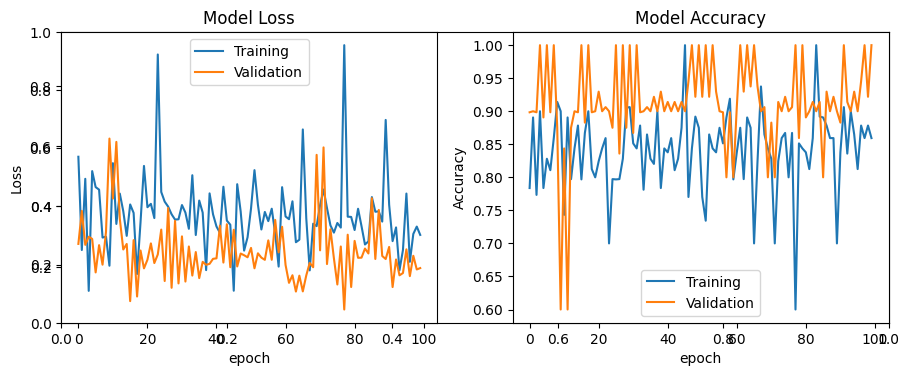

In [ ]:
print("Trained on", MODEL)
print("The Model Accuracy for Train data is: ", "{:.2%}".format(Training_Accuracy[1]))
print("The Model Accuracy for Validation data is: ", "{:.2%}".format(Validation_Accuracy[1]))
print("FINAL VALIDATION ACCURACY MEAN-5: ", np.mean(final_accuracy))
# Loss and Accuracy
plt.subplots(figsize=(9,3.5))
plt.tight_layout()
display_training_curves(history.history['loss'], history.history['val_loss'], 'Loss', 121)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy', 122)

# **Evaluation**

**Predict**

In [ ]:
# True label
true_labels = test_generator.classes  # Get label of valid_generator
# Prediction label
predictions = model.predict(x=test_generator, steps=len(test_generator),verbose = 0)
pred_labels = np.argmax(predictions, axis=-1)

**Confusion Matrix**

Confusion matrix, without normalization
[[16  0  4  0]
 [ 0 23  7  1]
 [ 0  0 57  1]
 [ 0  0  8 21]]
Normalized confusion matrix
[[0.8  0.   0.2  0.  ]
 [0.   0.74 0.23 0.03]
 [0.   0.   0.98 0.02]
 [0.   0.   0.28 0.72]]


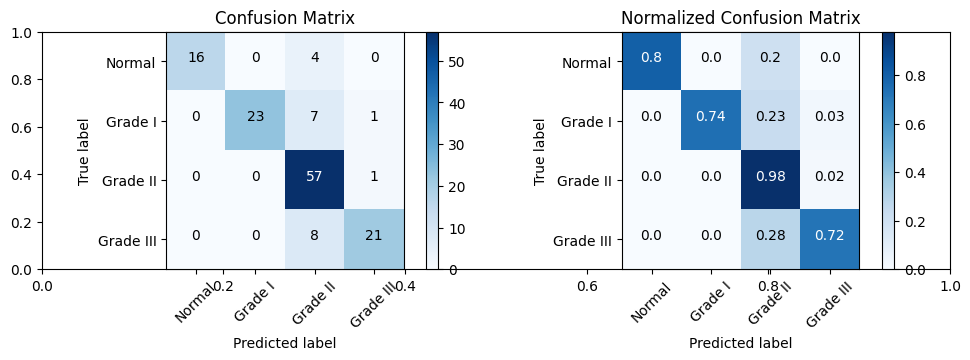

In [ ]:
# Plot Confusion Matrix
cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels)
plt.subplots(figsize=(10,4))
plot_confusion_matrix(cm=cm, classes=IMAGE_CLASSES, title='Confusion Matrix',normalize=False, subplot=121)
plot_confusion_matrix(cm=cm, classes=IMAGE_CLASSES, title='Normalized Confusion Matrix',normalize=True, subplot=122)

**Other Metrics**

**Show all images with predictions**

Total number of class is: 4 {'0Normal': 0, '1Grade I': 1, '2Grade II': 2, '3Grade III': 3}
Total image in generator is:  [20, 31, 58, 29]
Folder names:['0Normal', '1Grade I', '2Grade II', '3Grade III']
Correctly predicted: [16, 23, 57, 21]
Wrongly predicted: [4, 8, 1, 8]
True Class: 0Normal
Total images: 20 | Correctly predicted: 16 | Wrongly predicted: 4


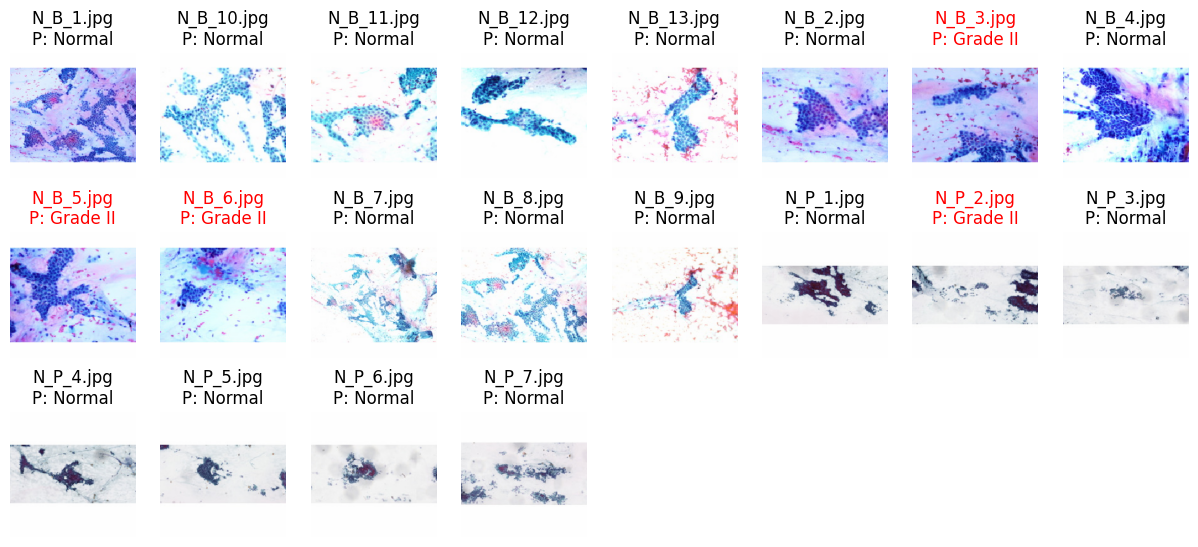

True Class: 1Grade I
Total images: 31 | Correctly predicted: 23 | Wrongly predicted: 8


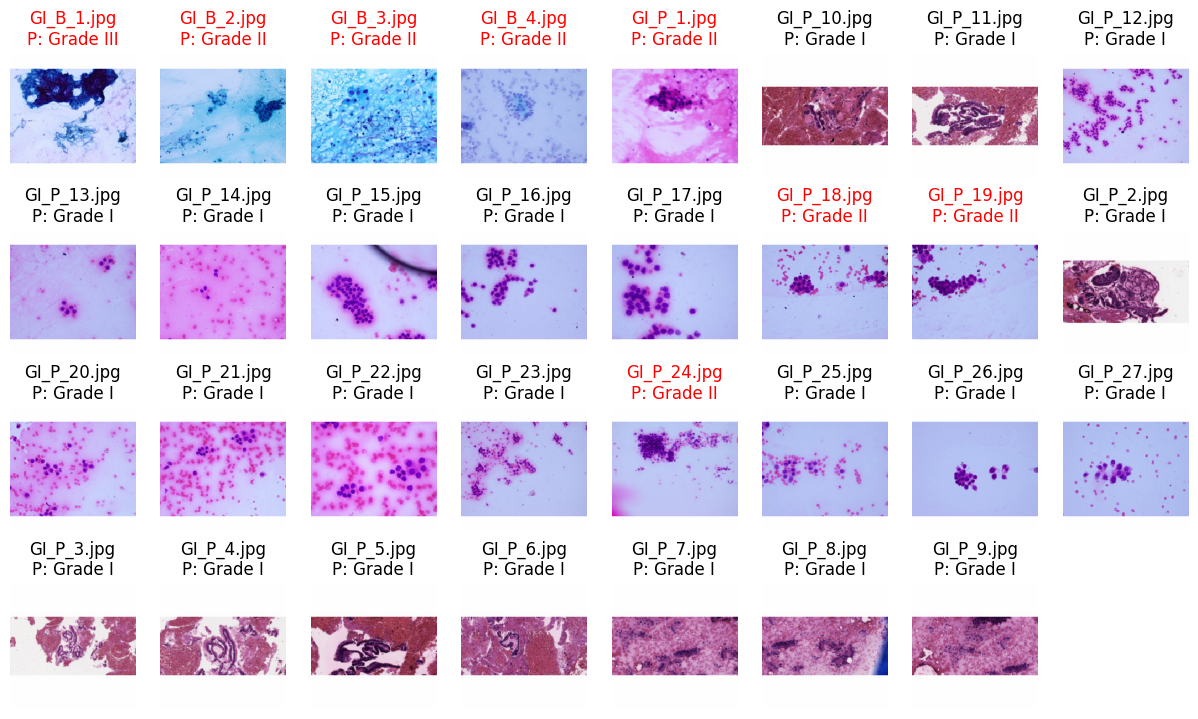

True Class: 2Grade II
Total images: 58 | Correctly predicted: 57 | Wrongly predicted: 1


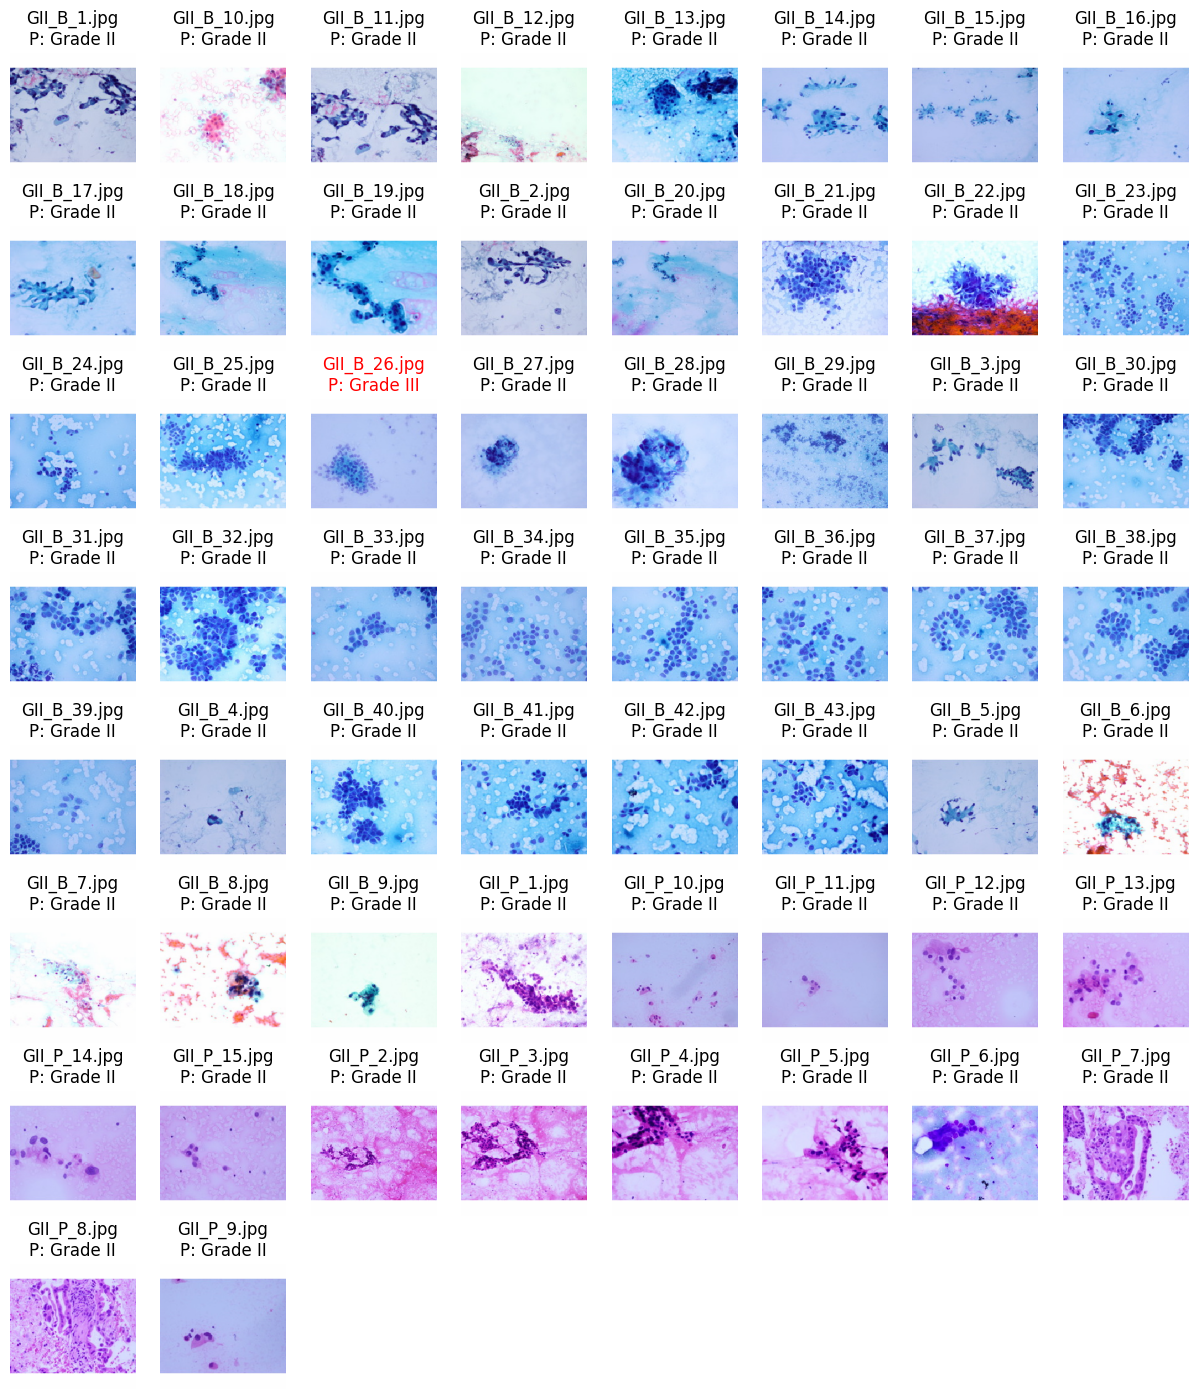

True Class: 3Grade III
Total images: 29 | Correctly predicted: 21 | Wrongly predicted: 8


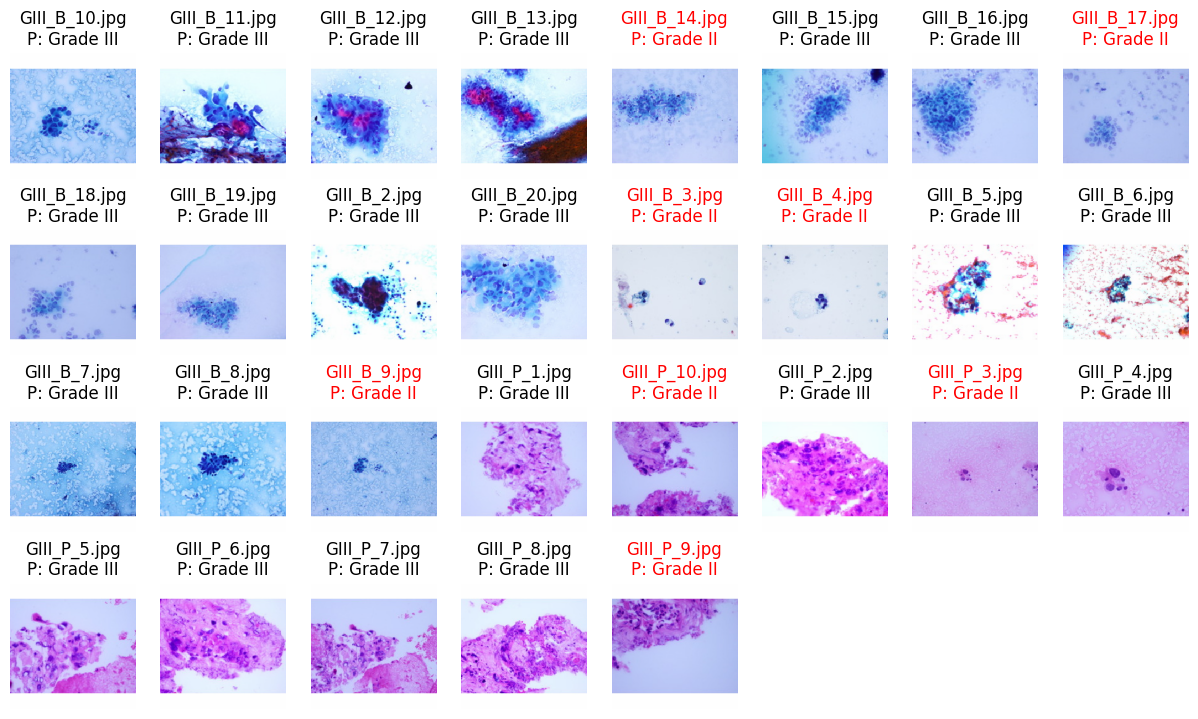

In [ ]:
show_all_prediction_image(test_path, test_generator, true_labels, pred_labels) # Argument:(Path of test dataset, test generator to generate image, true labels generated by test generator, predicted labels generated by model on test dataset)

In [ ]:
model.save('/content/drive/MyDrive/PCGIPI/savedmodels/Densenet201.h5')

In [ ]:
IMAGE_CLASSES = ['Normal','Grade I','Grade II','Grade III']         # Naming Classes (The names must be in the same order as in dataset folder (usually alphabetically))
MODEL = 'Xception'           # ["Xception", "VGG16", "VGG19", "ResNet50V2", "ResNet101V2", "ResNet152V2", "InceptionV3", "InceptionResNetV2", "MobileNetV2", "DenseNet121", "DenseNet169", "DenseNet201", "NASNetMobile", "NASNetLarge"]         # Name of the model to save after training
BATCH_SIZE = 64  # {type: "int"}# Mini-batch size
SEED = 2020                     # Fixed randomness For reproducible result
EPOCH = 100                     #  {type: "int"}Epoch
python_random.seed(SEED)        # necessary for starting core Python generated random numbers in a well-defined state.
np.random.seed(SEED)            # necessary for starting Numpy generated random numbers in a well-defined state.
tf.random.set_seed(SEED)        # will make random number generation in the TensorFlow backend have a well-defined initial state.

IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL = get_pretrained_model_input_size(MODEL)
print("Training on", MODEL)
print("Input:",IMAGE_WIDTH,'x',IMAGE_HEIGHT,'x',IMAGE_CHANNEL)

Training on Xception
Input: 299 x 299 x 3


In [ ]:
train_generator = get_train_generator()
valid_generator = get_valid_generator()
test_generator = get_test_generator()
# Check number of image in each class
train_freq = get_freq_data(train_generator)
valid_freq = get_freq_data(valid_generator)
total_freq = np.array(train_freq) + np.array(valid_freq)
valid_data_freq = np.array(valid_freq)/total_freq
print("Valid data Percentage:",valid_data_freq)

Getting train generator...
Found 3201 images belonging to 4 classes.
Getting valid generator...
Found 138 images belonging to 4 classes.
Getting test generator...
Found 138 images belonging to 4 classes.
Total number of class is: 4 {'0Normal': 0, '1Grade I': 1, '2Grade II': 2, '3Grade III': 3}
Total image in generator is:  [540, 714, 1292, 655]
Total number of class is: 4 {'0Normal': 0, '1Grade I': 1, '2Grade II': 2, '3Grade III': 3}
Total image in generator is:  [20, 31, 58, 29]
Valid data Percentage: [0.03571429 0.04161074 0.04296296 0.04239766]


In [ ]:
model = get_pretrained_model(MODEL, weights = 'imagenet', unfreeze_last_layer = 0, print_summary = False, print_fine_tuning_summary = True)

Xception pre-trained model selected
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
###################### AFTER FINE TUNING ########################


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 10, 10, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 204800)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      52,429,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,291,564 (279.59 MB)

 Trainable params: 52,430,084 (200.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

Xception pre-trained model selected


In [ ]:
time_start = time.time()
history = model.fit(
    x = train_generator,
    validation_data = valid_generator,
    epochs = EPOCH,
    verbose = 1,
    steps_per_epoch = train_generator.samples // train_generator.batch_size ,
    validation_steps = valid_generator.samples // valid_generator.batch_size
)
print("Training done. Evaluating...")
time_end = time.time()
final_accuracy = history.history["val_accuracy"][-5:]
Training_Accuracy = model.evaluate(train_generator, steps=train_generator.samples // train_generator.batch_size)
Validation_Accuracy = model.evaluate(test_generator, steps=valid_generator.samples // valid_generator.batch_size)
print("Finish!")

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.5155 - loss: 7.9352 - val_accuracy: 0.5469 - val_loss: 1.2854
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 200ms/step - accuracy: 0.6719 - loss: 0.8328 - val_accuracy: 0.2000 - val_loss: 1.3216
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.6636 - loss: 0.8438 - val_accuracy: 0.4766 - val_loss: 1.3731
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7344 - loss: 0.7251 - val_accuracy: 0.6000 - val_loss: 1.2587
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.6948 - loss: 0.7630 - val_accuracy: 0.3359 - val_loss: 1.4302
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7031 - loss: 0.6722 - val_accuracy: 0.7000 - val_loss: 1.9758
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.7087 - loss: 0.7150 - val_accuracy: 0.4922 - val_loss: 1.2553
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8281 - loss: 0.5476 - val_accuracy: 0.400

Trained on Xception
The Model Accuracy for Train data is:  89.06%
The Model Accuracy for Validation data is:  82.81%
FINAL VALIDATION ACCURACY MEAN-5:  0.8096875071525573


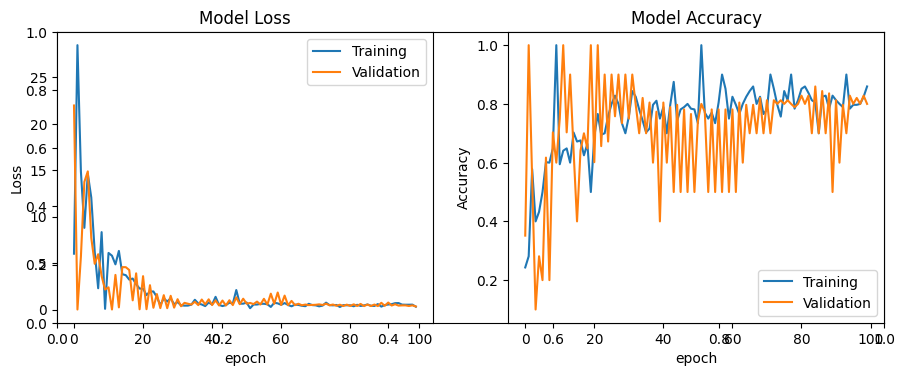

In [ ]:
print("Trained on", MODEL)
print("The Model Accuracy for Train data is: ", "{:.2%}".format(Training_Accuracy[1]))
print("The Model Accuracy for Validation data is: ", "{:.2%}".format(Validation_Accuracy[1]))
print("FINAL VALIDATION ACCURACY MEAN-5: ", np.mean(final_accuracy))
# Loss and Accuracy
plt.subplots(figsize=(9,3.5))
plt.tight_layout()
display_training_curves(history.history['loss'], history.history['val_loss'], 'Loss', 121)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy', 122)

In [ ]:
model.save('/content/drive/MyDrive/PCGIPI/savedmodels/Xception.h5')

In [7]:
IMAGE_CLASSES = ['Normal','Grade I','Grade II','Grade III']         # Naming Classes (The names must be in the same order as in dataset folder (usually alphabetically))
MODEL = 'VGG16'           # ["Xception", "VGG16", "VGG19", "ResNet50V2", "ResNet101V2", "ResNet152V2", "InceptionV3", "InceptionResNetV2", "MobileNetV2", "DenseNet121", "DenseNet169", "DenseNet201", "NASNetMobile", "NASNetLarge"]         # Name of the model to save after training
BATCH_SIZE = 64  # {type: "int"}# Mini-batch size
SEED = 2020                     # Fixed randomness For reproducible result
EPOCH = 100                     #  {type: "int"}Epoch
python_random.seed(SEED)        # necessary for starting core Python generated random numbers in a well-defined state.
np.random.seed(SEED)            # necessary for starting Numpy generated random numbers in a well-defined state.
tf.random.set_seed(SEED)        # will make random number generation in the TensorFlow backend have a well-defined initial state.

IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL = get_pretrained_model_input_size(MODEL)
print("Training on", MODEL)
print("Input:",IMAGE_WIDTH,'x',IMAGE_HEIGHT,'x',IMAGE_CHANNEL)

Training on VGG16
Input: 224 x 224 x 3


In [8]:
train_generator = get_train_generator()
valid_generator = get_valid_generator()
test_generator = get_test_generator()
# Check number of image in each class
train_freq = get_freq_data(train_generator)
valid_freq = get_freq_data(valid_generator)
total_freq = np.array(train_freq) + np.array(valid_freq)
valid_data_freq = np.array(valid_freq)/total_freq
print("Valid data Percentage:",valid_data_freq)

Getting train generator...
Found 3201 images belonging to 4 classes.
Getting valid generator...
Found 138 images belonging to 4 classes.
Getting test generator...
Found 138 images belonging to 4 classes.
Total number of class is: 4 {'0Normal': 0, '1Grade I': 1, '2Grade II': 2, '3Grade III': 3}
Total image in generator is:  [540, 714, 1292, 655]
Total number of class is: 4 {'0Normal': 0, '1Grade I': 1, '2Grade II': 2, '3Grade III': 3}
Total image in generator is:  [20, 31, 58, 29]
Valid data Percentage: [0.03571429 0.04161074 0.04296296 0.04239766]


In [ ]:
model = get_pretrained_model(MODEL, weights = 'imagenet', unfreeze_last_layer = 0, print_summary = False, print_fine_tuning_summary = True)

VGG16 pre-trained model selected
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
###################### AFTER FINE TUNING ########################


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

VGG16 pre-trained model selected


In [ ]:
time_start = time.time()
history = model.fit(
    x = train_generator,
    validation_data = valid_generator,
    epochs = EPOCH,
    verbose = 1,
    steps_per_epoch = train_generator.samples // train_generator.batch_size ,
    validation_steps = valid_generator.samples // valid_generator.batch_size
)
print("Training done. Evaluating...")
time_end = time.time()
final_accuracy = history.history["val_accuracy"][-5:]
Training_Accuracy = model.evaluate(train_generator, steps=train_generator.samples // train_generator.batch_size)
Validation_Accuracy = model.evaluate(test_generator, steps=valid_generator.samples // valid_generator.batch_size)
print("Finish!")

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.2969 - loss: 4.0859 - val_accuracy: 0.1484 - val_loss: 13.2264
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.2000 - loss: 7.9018 - val_accuracy: 1.0000 - val_loss: 4.9553e-05
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.2188 - loss: 13.2280 - val_accuracy: 0.4531 - val_loss: 7.6022
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5000 - loss: 6.2911 - val_accuracy: 0.0000e+00 - val_loss: 10.9664
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3613 - loss: 10.7531 - val_accuracy: 0.4531 - val_loss: 3.1477
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.4531 - loss: 3.4774 - val_accuracy: 1.0000 - val_loss: 0.2103
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4115 - loss: 2.1580 - val_accuracy: 0.2344 - val_loss: 3.0485
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3000 - loss: 4.1349 - val_accuracy: 0.6000 - val_loss

Trained on VGG16
The Model Accuracy for Train data is:  84.38%
The Model Accuracy for Validation data is:  88.28%
FINAL VALIDATION ACCURACY MEAN-5:  0.8006250023841858


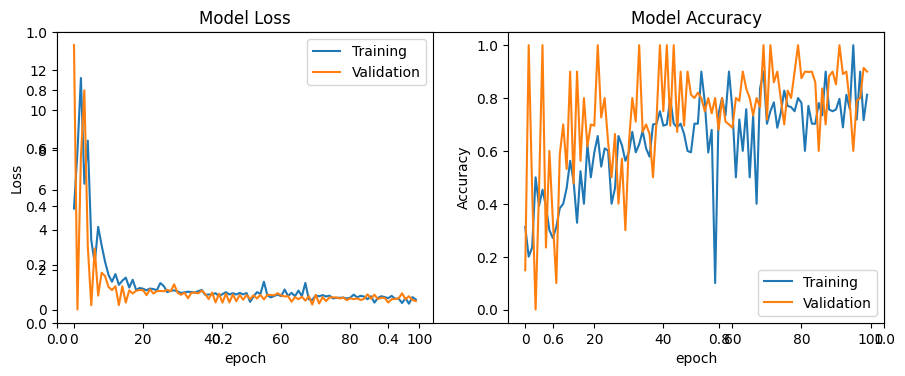

In [ ]:
print("Trained on", MODEL)
print("The Model Accuracy for Train data is: ", "{:.2%}".format(Training_Accuracy[1]))
print("The Model Accuracy for Validation data is: ", "{:.2%}".format(Validation_Accuracy[1]))
print("FINAL VALIDATION ACCURACY MEAN-5: ", np.mean(final_accuracy))
# Loss and Accuracy
plt.subplots(figsize=(9,3.5))
plt.tight_layout()
display_training_curves(history.history['loss'], history.history['val_loss'], 'Loss', 121)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy', 122)

In [ ]:
model.save('/content/drive/MyDrive/PCGIPI/savedmodels/VGG16.h5')

In [9]:
IMAGE_CLASSES = ['Normal','Grade I','Grade II','Grade III']         # Naming Classes (The names must be in the same order as in dataset folder (usually alphabetically))
MODEL = 'VGG19'           # ["Xception", "VGG16", "VGG19", "ResNet50V2", "ResNet101V2", "ResNet152V2", "InceptionV3", "InceptionResNetV2", "MobileNetV2", "DenseNet121", "DenseNet169", "DenseNet201", "NASNetMobile", "NASNetLarge"]         # Name of the model to save after training
BATCH_SIZE = 64  # {type: "int"}# Mini-batch size
SEED = 2020                     # Fixed randomness For reproducible result
EPOCH = 100                     #  {type: "int"}Epoch
python_random.seed(SEED)        # necessary for starting core Python generated random numbers in a well-defined state.
np.random.seed(SEED)            # necessary for starting Numpy generated random numbers in a well-defined state.
tf.random.set_seed(SEED)        # will make random number generation in the TensorFlow backend have a well-defined initial state.

IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL = get_pretrained_model_input_size(MODEL)
print("Training on", MODEL)
print("Input:",IMAGE_WIDTH,'x',IMAGE_HEIGHT,'x',IMAGE_CHANNEL)

Training on VGG19
Input: 224 x 224 x 3


In [10]:
train_generator = get_train_generator()
valid_generator = get_valid_generator()
test_generator = get_test_generator()
# Check number of image in each class
train_freq = get_freq_data(train_generator)
valid_freq = get_freq_data(valid_generator)
total_freq = np.array(train_freq) + np.array(valid_freq)
valid_data_freq = np.array(valid_freq)/total_freq
print("Valid data Percentage:",valid_data_freq)

Getting train generator...
Found 3201 images belonging to 4 classes.
Getting valid generator...
Found 138 images belonging to 4 classes.
Getting test generator...
Found 138 images belonging to 4 classes.
Total number of class is: 4 {'0Normal': 0, '1Grade I': 1, '2Grade II': 2, '3Grade III': 3}
Total image in generator is:  [540, 714, 1292, 655]
Total number of class is: 4 {'0Normal': 0, '1Grade I': 1, '2Grade II': 2, '3Grade III': 3}
Total image in generator is:  [20, 31, 58, 29]
Valid data Percentage: [0.03571429 0.04161074 0.04296296 0.04239766]


In [ ]:
model = get_pretrained_model(MODEL, weights = 'imagenet', unfreeze_last_layer = 0, print_summary = False, print_fine_tuning_summary = True)

VGG19 pre-trained model selected
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
###################### AFTER FINE TUNING ########################


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 7, 7, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,448,196 (100.89 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

VGG19 pre-trained model selected


In [ ]:
time_start = time.time()
history = model.fit(
    x = train_generator,
    validation_data = valid_generator,
    epochs = EPOCH,
    verbose = 1,
    steps_per_epoch = train_generator.samples // train_generator.batch_size ,
    validation_steps = valid_generator.samples // valid_generator.batch_size
)
print("Training done. Evaluating...")
time_end = time.time()
final_accuracy = history.history["val_accuracy"][-5:]
Training_Accuracy = model.evaluate(train_generator, steps=train_generator.samples // train_generator.batch_size)
Validation_Accuracy = model.evaluate(test_generator, steps=valid_generator.samples // valid_generator.batch_size)
print("Finish!")

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.1498 - loss: 2.3145 - val_accuracy: 0.1484 - val_loss: 9.5401
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step - accuracy: 0.2188 - loss: 9.9716 - val_accuracy: 0.0000e+00 - val_loss: 4.1926
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 915ms/step - accuracy: 0.2493 - loss: 8.5283 - val_accuracy: 0.4531 - val_loss: 6.5415
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4531 - loss: 7.6191 - val_accuracy: 0.0000e+00 - val_loss: 1.8092
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 923ms/step - accuracy: 0.4573 - loss: 4.7625 - val_accuracy: 0.2500 - val_loss: 3.1475
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.2969 - loss: 3.6187 - val_accuracy: 0.0000e+00 - val_loss: 1.9897
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.2969 - loss: 3.7698 - val_accuracy: 0.2578 - val_loss: 1.5923
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5000 - loss: 2.2740 - val_accuracy: 0.0000e

Trained on VGG19
The Model Accuracy for Train data is:  87.50%
The Model Accuracy for Validation data is:  83.59%
FINAL VALIDATION ACCURACY MEAN-5:  0.9159374952316284


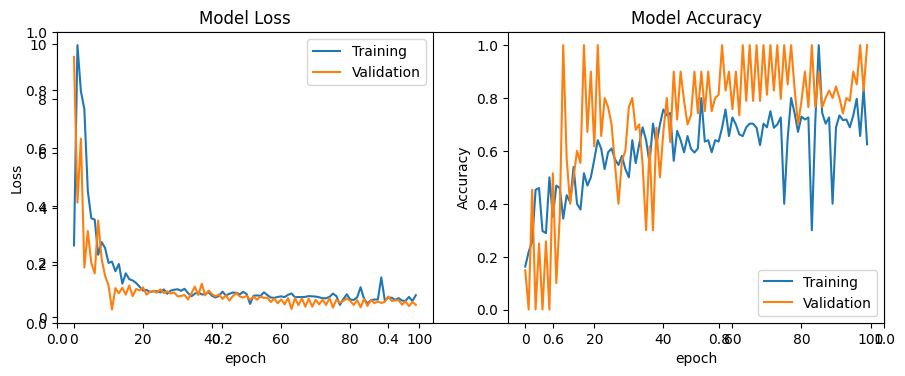

In [ ]:
print("Trained on", MODEL)
print("The Model Accuracy for Train data is: ", "{:.2%}".format(Training_Accuracy[1]))
print("The Model Accuracy for Validation data is: ", "{:.2%}".format(Validation_Accuracy[1]))
print("FINAL VALIDATION ACCURACY MEAN-5: ", np.mean(final_accuracy))
# Loss and Accuracy
plt.subplots(figsize=(9,3.5))
plt.tight_layout()
display_training_curves(history.history['loss'], history.history['val_loss'], 'Loss', 121)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy', 122)

In [ ]:
model.save('/content/drive/MyDrive/PCGIPI/savedmodels/VGG19.h5')

In [11]:
IMAGE_CLASSES = ['Normal','Grade I','Grade II','Grade III']         # Naming Classes (The names must be in the same order as in dataset folder (usually alphabetically))
MODEL = 'ResNet50V2'           # ["Xception", "VGG16", "VGG19", "ResNet50V2", "ResNet101V2", "ResNet152V2", "InceptionV3", "InceptionResNetV2", "MobileNetV2", "DenseNet121", "DenseNet169", "DenseNet201", "NASNetMobile", "NASNetLarge"]         # Name of the model to save after training
BATCH_SIZE = 64  # {type: "int"}# Mini-batch size
SEED = 2020                     # Fixed randomness For reproducible result
EPOCH = 100                     #  {type: "int"}Epoch
python_random.seed(SEED)        # necessary for starting core Python generated random numbers in a well-defined state.
np.random.seed(SEED)            # necessary for starting Numpy generated random numbers in a well-defined state.
tf.random.set_seed(SEED)        # will make random number generation in the TensorFlow backend have a well-defined initial state.

IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL = get_pretrained_model_input_size(MODEL)
print("Training on", MODEL)
print("Input:",IMAGE_WIDTH,'x',IMAGE_HEIGHT,'x',IMAGE_CHANNEL)

Training on ResNet50V2
Input: 224 x 224 x 3


In [12]:
train_generator = get_train_generator()
valid_generator = get_valid_generator()
test_generator = get_test_generator()
# Check number of image in each class
train_freq = get_freq_data(train_generator)
valid_freq = get_freq_data(valid_generator)
total_freq = np.array(train_freq) + np.array(valid_freq)
valid_data_freq = np.array(valid_freq)/total_freq
print("Valid data Percentage:",valid_data_freq)

Getting train generator...
Found 3201 images belonging to 4 classes.
Getting valid generator...
Found 138 images belonging to 4 classes.
Getting test generator...
Found 138 images belonging to 4 classes.
Total number of class is: 4 {'0Normal': 0, '1Grade I': 1, '2Grade II': 2, '3Grade III': 3}
Total image in generator is:  [540, 714, 1292, 655]
Total number of class is: 4 {'0Normal': 0, '1Grade I': 1, '2Grade II': 2, '3Grade III': 3}
Total image in generator is:  [20, 31, 58, 29]
Valid data Percentage: [0.03571429 0.04161074 0.04296296 0.04239766]


In [ ]:
model = get_pretrained_model(MODEL, weights = 'imagenet', unfreeze_last_layer = 0, print_summary = False, print_fine_tuning_summary = True)

ResNet50V2 pre-trained model selected
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
###################### AFTER FINE TUNING ########################


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,256,196 (187.90 MB)

 Trainable params: 25,691,396 (98.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

ResNet50V2 pre-trained model selected


In [ ]:
time_start = time.time()
history = model.fit(
    x = train_generator,
    validation_data = valid_generator,
    epochs = EPOCH,
    verbose = 1,
    steps_per_epoch = train_generator.samples // train_generator.batch_size ,
    validation_steps = valid_generator.samples // valid_generator.batch_size
)
print("Training done. Evaluating...")
time_end = time.time()
final_accuracy = history.history["val_accuracy"][-5:]
Training_Accuracy = model.evaluate(train_generator, steps=train_generator.samples // train_generator.batch_size)
Validation_Accuracy = model.evaluate(test_generator, steps=valid_generator.samples // valid_generator.batch_size)
print("Finish!")

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 9s/step - accuracy: 0.1782 - loss: 5.4557 - val_accuracy: 0.3594 - val_loss: 10.1341
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3750 - loss: 25.2399 - val_accuracy: 0.0000e+00 - val_loss: 22.1792
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 801ms/step - accuracy: 0.4635 - loss: 10.3768 - val_accuracy: 0.5859 - val_loss: 3.1149
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6000 - loss: 2.1868 - val_accuracy: 1.0000 - val_loss: 0.0033
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 741ms/step - accuracy: 0.4858 - loss: 5.1457 - val_accuracy: 0.3281 - val_loss: 4.7828
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 436ms/step - accuracy: 0.5469 - loss: 4.5197 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 825ms/step - accuracy: 0.5365 - loss: 4.3429 - val_accuracy: 0.6719 - val_loss: 1.8315
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6000 - loss: 2.5840 - val_accuracy: 0.7000 -

Trained on ResNet50V2
Time taken: 0:04:36 (hh:mm:ss)
The Model Accuracy for Train data is:  88.28%
The Model Accuracy for Validation data is:  84.38%
FINAL VALIDATION ACCURACY MEAN-5:  0.934375


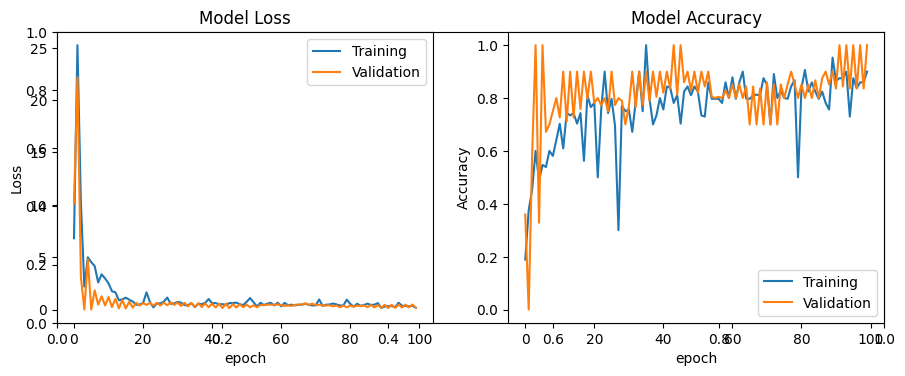

In [ ]:
print("Trained on", MODEL)
print("The Model Accuracy for Train data is: ", "{:.2%}".format(Training_Accuracy[1]))
print("The Model Accuracy for Validation data is: ", "{:.2%}".format(Validation_Accuracy[1]))
print("FINAL VALIDATION ACCURACY MEAN-5: ", np.mean(final_accuracy))
# Loss and Accuracy
plt.subplots(figsize=(9,3.5))
plt.tight_layout()
display_training_curves(history.history['loss'], history.history['val_loss'], 'Loss', 121)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy', 122)

In [ ]:
model.save('/content/drive/MyDrive/PCGIPI/savedmodels/ResNet50V2.h5')

In [13]:
IMAGE_CLASSES = ['Normal','Grade I','Grade II','Grade III']         # Naming Classes (The names must be in the same order as in dataset folder (usually alphabetically))
MODEL = 'ResNet101V2'           # ["Xception", "VGG16", "VGG19", "ResNet50V2", "ResNet101V2", "ResNet152V2", "InceptionV3", "InceptionResNetV2", "MobileNetV2", "DenseNet121", "DenseNet169", "DenseNet201", "NASNetMobile", "NASNetLarge"]         # Name of the model to save after training
BATCH_SIZE = 64  # {type: "int"}# Mini-batch size
SEED = 2020                     # Fixed randomness For reproducible result
EPOCH = 100                     #  {type: "int"}Epoch
python_random.seed(SEED)        # necessary for starting core Python generated random numbers in a well-defined state.
np.random.seed(SEED)            # necessary for starting Numpy generated random numbers in a well-defined state.
tf.random.set_seed(SEED)        # will make random number generation in the TensorFlow backend have a well-defined initial state.

IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL = get_pretrained_model_input_size(MODEL)
print("Training on", MODEL)
print("Input:",IMAGE_WIDTH,'x',IMAGE_HEIGHT,'x',IMAGE_CHANNEL)

Training on ResNet101V2
Input: 224 x 224 x 3


In [14]:
train_generator = get_train_generator()
valid_generator = get_valid_generator()
test_generator = get_test_generator()
# Check number of image in each class
train_freq = get_freq_data(train_generator)
valid_freq = get_freq_data(valid_generator)
total_freq = np.array(train_freq) + np.array(valid_freq)
valid_data_freq = np.array(valid_freq)/total_freq
print("Valid data Percentage:",valid_data_freq)

Getting train generator...
Found 3201 images belonging to 4 classes.
Getting valid generator...
Found 138 images belonging to 4 classes.
Getting test generator...
Found 138 images belonging to 4 classes.
Total number of class is: 4 {'0Normal': 0, '1Grade I': 1, '2Grade II': 2, '3Grade III': 3}
Total image in generator is:  [540, 714, 1292, 655]
Total number of class is: 4 {'0Normal': 0, '1Grade I': 1, '2Grade II': 2, '3Grade III': 3}
Total image in generator is:  [20, 31, 58, 29]
Valid data Percentage: [0.03571429 0.04161074 0.04296296 0.04239766]


In [ ]:
model = get_pretrained_model(MODEL, weights = 'imagenet', unfreeze_last_layer = 0, print_summary = False, print_fine_tuning_summary = True)

ResNet101V2 pre-trained model selected
171317808/171317808 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
###################### AFTER FINE TUNING ########################


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)             │ (None, 7, 7, 2048)          │      42,626,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,317,956 (260.61 MB)

 Trainable params: 25,691,396 (98.00 MB)

 Non-trainable params: 42,626,560 (162.61 MB)

ResNet101V2 pre-trained model selected


In [ ]:
time_start = time.time()
history = model.fit(
    x = train_generator,
    validation_data = valid_generator,
    epochs = EPOCH,
    verbose = 1,
    steps_per_epoch = train_generator.samples // train_generator.batch_size ,
    validation_steps = valid_generator.samples // valid_generator.batch_size
)
print("Training done. Evaluating...")
time_end = time.time()
final_accuracy = history.history["val_accuracy"][-5:]
Training_Accuracy = model.evaluate(train_generator, steps=train_generator.samples // train_generator.batch_size)
Validation_Accuracy = model.evaluate(test_generator, steps=valid_generator.samples // valid_generator.batch_size)
print("Finish!")

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 45s 12s/step - accuracy: 0.2135 - loss: 12.7476 - val_accuracy: 0.4531 - val_loss: 33.5159
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 5s/step - accuracy: 0.3906 - loss: 34.7753 - val_accuracy: 0.0000e+00 - val_loss: 82.8392
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 878ms/step - accuracy: 0.4872 - loss: 27.1966 - val_accuracy: 0.5859 - val_loss: 11.0006
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.3906 - loss: 22.8453 - val_accuracy: 0.0000e+00 - val_loss: 47.0199
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 844ms/step - accuracy: 0.5298 - loss: 12.4875 - val_accuracy: 0.5391 - val_loss: 6.9458
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5469 - loss: 8.4856 - val_accuracy: 0.6000 - val_loss: 2.5082
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5000 - loss: 5.0958 - val_accuracy: 0.4453 - val_loss: 5.6284
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5469 - loss: 5.6025 - val_accuracy: 1.

Trained on ResNet101V2
Time taken: 0:04:40 (hh:mm:ss)
The Model Accuracy for Train data is:  84.38%
The Model Accuracy for Validation data is:  89.84%
FINAL VALIDATION ACCURACY MEAN-5:  0.95625


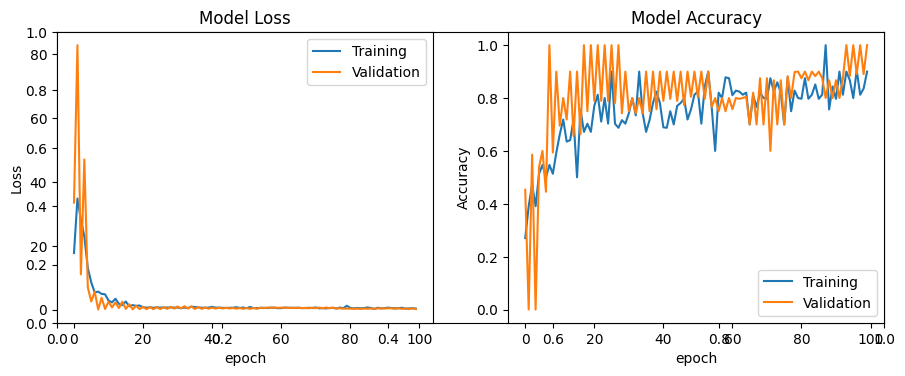

In [ ]:
print("Trained on", MODEL)
print("The Model Accuracy for Train data is: ", "{:.2%}".format(Training_Accuracy[1]))
print("The Model Accuracy for Validation data is: ", "{:.2%}".format(Validation_Accuracy[1]))
print("FINAL VALIDATION ACCURACY MEAN-5: ", np.mean(final_accuracy))
# Loss and Accuracy
plt.subplots(figsize=(9,3.5))
plt.tight_layout()
display_training_curves(history.history['loss'], history.history['val_loss'], 'Loss', 121)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy', 122)

In [ ]:
model.save('/content/drive/MyDrive/PCGIPI/savedmodels/ResNet101V2.h5')

In [15]:
IMAGE_CLASSES = ['Normal','Grade I','Grade II','Grade III']         # Naming Classes (The names must be in the same order as in dataset folder (usually alphabetically))
MODEL = 'ResNet152V2'           # ["Xception", "VGG16", "VGG19", "ResNet50V2", "ResNet101V2", "ResNet152V2", "InceptionV3", "InceptionResNetV2", "MobileNetV2", "DenseNet121", "DenseNet169", "DenseNet201", "NASNetMobile", "NASNetLarge"]         # Name of the model to save after training
BATCH_SIZE = 64  # {type: "int"}# Mini-batch size
SEED = 2020                     # Fixed randomness For reproducible result
EPOCH = 100                     #  {type: "int"}Epoch
python_random.seed(SEED)        # necessary for starting core Python generated random numbers in a well-defined state.
np.random.seed(SEED)            # necessary for starting Numpy generated random numbers in a well-defined state.
tf.random.set_seed(SEED)        # will make random number generation in the TensorFlow backend have a well-defined initial state.

IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL = get_pretrained_model_input_size(MODEL)
print("Training on", MODEL)
print("Input:",IMAGE_WIDTH,'x',IMAGE_HEIGHT,'x',IMAGE_CHANNEL)

Training on ResNet152V2
Input: 224 x 224 x 3


In [16]:
train_generator = get_train_generator()
valid_generator = get_valid_generator()
test_generator = get_test_generator()
# Check number of image in each class
train_freq = get_freq_data(train_generator)
valid_freq = get_freq_data(valid_generator)
total_freq = np.array(train_freq) + np.array(valid_freq)
valid_data_freq = np.array(valid_freq)/total_freq
print("Valid data Percentage:",valid_data_freq)

Getting train generator...
Found 3201 images belonging to 4 classes.
Getting valid generator...
Found 138 images belonging to 4 classes.
Getting test generator...
Found 138 images belonging to 4 classes.
Total number of class is: 4 {'0Normal': 0, '1Grade I': 1, '2Grade II': 2, '3Grade III': 3}
Total image in generator is:  [540, 714, 1292, 655]
Total number of class is: 4 {'0Normal': 0, '1Grade I': 1, '2Grade II': 2, '3Grade III': 3}
Total image in generator is:  [20, 31, 58, 29]
Valid data Percentage: [0.03571429 0.04161074 0.04296296 0.04239766]


In [ ]:
model = get_pretrained_model(MODEL, weights = 'imagenet', unfreeze_last_layer = 0, print_summary = False, print_fine_tuning_summary = True)

ResNet152V2 pre-trained model selected
234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
###################### AFTER FINE TUNING ########################


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet152v2 (Functional)             │ (None, 7, 7, 2048)          │      58,331,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 84,023,044 (320.52 MB)

 Trainable params: 25,691,396 (98.00 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

ResNet152V2 pre-trained model selected


In [ ]:
time_start = time.time()
history = model.fit(
    x = train_generator,
    validation_data = valid_generator,
    epochs = EPOCH,
    verbose = 1,
    steps_per_epoch = train_generator.samples // train_generator.batch_size ,
    validation_steps = valid_generator.samples // valid_generator.batch_size
)
print("Training done. Evaluating...")
time_end = time.time()
final_accuracy = history.history["val_accuracy"][-5:]
Training_Accuracy = model.evaluate(train_generator, steps=train_generator.samples // train_generator.batch_size)
Validation_Accuracy = model.evaluate(test_generator, steps=valid_generator.samples // valid_generator.batch_size)
print("Finish!")

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 44s 18s/step - accuracy: 0.3946 - loss: 15.7532 - val_accuracy: 0.2188 - val_loss: 19.4661
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.2500 - loss: 22.8998 - val_accuracy: 0.0000e+00 - val_loss: 27.9287
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.2934 - loss: 22.1165 - val_accuracy: 0.5000 - val_loss: 5.4341
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4688 - loss: 9.6051 - val_accuracy: 0.4000 - val_loss: 6.5441
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5260 - loss: 8.1001 - val_accuracy: 0.4453 - val_loss: 6.9346
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.2000 - loss: 14.1131 - val_accuracy: 0.9000 - val_loss: 0.6013
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5260 - loss: 8.4040 - val_accuracy: 0.5469 - val_loss: 5.6146
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5000 - loss: 13.2248 - val_accuracy: 0.9000 - val_l

Trained on ResNet152V2
The Model Accuracy for Train data is:  92.97%
The Model Accuracy for Validation data is:  85.94%
FINAL VALIDATION ACCURACY MEAN-5:  0.8853124856948853


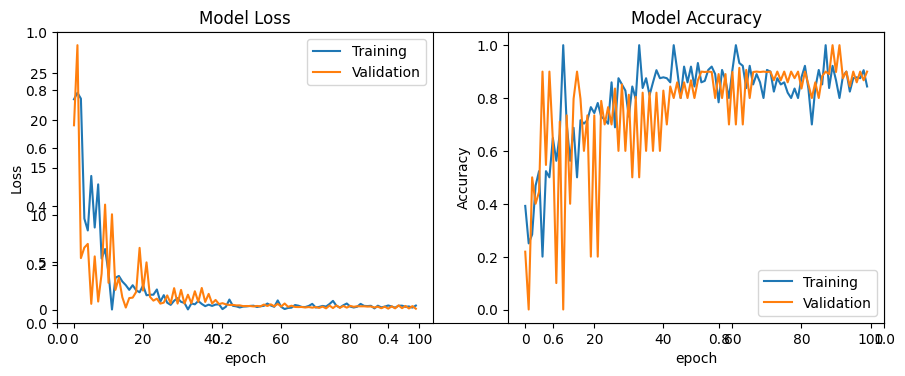

In [ ]:
print("Trained on", MODEL)
print("The Model Accuracy for Train data is: ", "{:.2%}".format(Training_Accuracy[1]))
print("The Model Accuracy for Validation data is: ", "{:.2%}".format(Validation_Accuracy[1]))
print("FINAL VALIDATION ACCURACY MEAN-5: ", np.mean(final_accuracy))
# Loss and Accuracy
plt.subplots(figsize=(9,3.5))
plt.tight_layout()
display_training_curves(history.history['loss'], history.history['val_loss'], 'Loss', 121)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy', 122)

In [ ]:
model.save('/content/drive/MyDrive/PCGIPI/savedmodels/ResNet152V2.h5')

In [17]:
IMAGE_CLASSES = ['Normal','Grade I','Grade II','Grade III']         # Naming Classes (The names must be in the same order as in dataset folder (usually alphabetically))
MODEL = 'InceptionV3'           # ["Xception", "VGG16", "VGG19", "ResNet50V2", "ResNet101V2", "ResNet152V2", "InceptionV3", "InceptionResNetV2", "MobileNetV2", "DenseNet121", "DenseNet169", "DenseNet201", "NASNetMobile", "NASNetLarge"]         # Name of the model to save after training
BATCH_SIZE = 64  # {type: "int"}# Mini-batch size
SEED = 2020                     # Fixed randomness For reproducible result
EPOCH = 100                     #  {type: "int"}Epoch
python_random.seed(SEED)        # necessary for starting core Python generated random numbers in a well-defined state.
np.random.seed(SEED)            # necessary for starting Numpy generated random numbers in a well-defined state.
tf.random.set_seed(SEED)        # will make random number generation in the TensorFlow backend have a well-defined initial state.

IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL = get_pretrained_model_input_size(MODEL)
print("Training on", MODEL)
print("Input:",IMAGE_WIDTH,'x',IMAGE_HEIGHT,'x',IMAGE_CHANNEL)

Training on InceptionV3
Input: 299 x 299 x 3


In [18]:
train_generator = get_train_generator()
valid_generator = get_valid_generator()
test_generator = get_test_generator()
# Check number of image in each class
train_freq = get_freq_data(train_generator)
valid_freq = get_freq_data(valid_generator)
total_freq = np.array(train_freq) + np.array(valid_freq)
valid_data_freq = np.array(valid_freq)/total_freq
print("Valid data Percentage:",valid_data_freq)

Getting train generator...
Found 3201 images belonging to 4 classes.
Getting valid generator...
Found 138 images belonging to 4 classes.
Getting test generator...
Found 138 images belonging to 4 classes.
Total number of class is: 4 {'0Normal': 0, '1Grade I': 1, '2Grade II': 2, '3Grade III': 3}
Total image in generator is:  [540, 714, 1292, 655]
Total number of class is: 4 {'0Normal': 0, '1Grade I': 1, '2Grade II': 2, '3Grade III': 3}
Total image in generator is:  [20, 31, 58, 29]
Valid data Percentage: [0.03571429 0.04161074 0.04296296 0.04239766]


In [ ]:
model = get_pretrained_model(MODEL, weights = 'imagenet', unfreeze_last_layer = 0, print_summary = False, print_fine_tuning_summary = True)

InceptionV3 pre-trained model selected
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
###################### AFTER FINE TUNING ########################


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 8, 8, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │      33,554,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,358,500 (211.18 MB)

 Trainable params: 33,555,716 (128.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

InceptionV3 pre-trained model selected


In [ ]:
time_start = time.time()
history = model.fit(
    x = train_generator,
    validation_data = valid_generator,
    epochs = EPOCH,
    verbose = 1,
    steps_per_epoch = train_generator.samples // train_generator.batch_size ,
    validation_steps = valid_generator.samples // valid_generator.batch_size
)
print("Training done. Evaluating...")
time_end = time.time()
final_accuracy = history.history["val_accuracy"][-5:]
Training_Accuracy = model.evaluate(train_generator, steps=train_generator.samples // train_generator.batch_size)
Validation_Accuracy = model.evaluate(test_generator, steps=valid_generator.samples // valid_generator.batch_size)
print("Finish!")

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 47s 15s/step - accuracy: 0.2014 - loss: 9.5013 - val_accuracy: 0.4297 - val_loss: 32.0746
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.4062 - loss: 47.6159 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.2712 - loss: 67.7091 - val_accuracy: 0.2812 - val_loss: 47.1036
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.2656 - loss: 56.5731 - val_accuracy: 0.1000 - val_loss: 12.7579
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4604 - loss: 17.9243 - val_accuracy: 0.4688 - val_loss: 18.4595
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4844 - loss: 31.9569 - val_accuracy: 0.0000e+00 - val_loss: 31.0775
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 947ms/step - accuracy: 0.5104 - loss: 22.6962 - val_accuracy: 0.4531 - val_loss: 9.0488
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4688 - loss: 20.9381 - val_accuracy: 0.5

Trained on InceptionV3
The Model Accuracy for Train data is:  86.72%
The Model Accuracy for Validation data is:  79.69%
FINAL VALIDATION ACCURACY MEAN-5:  0.8603124856948853


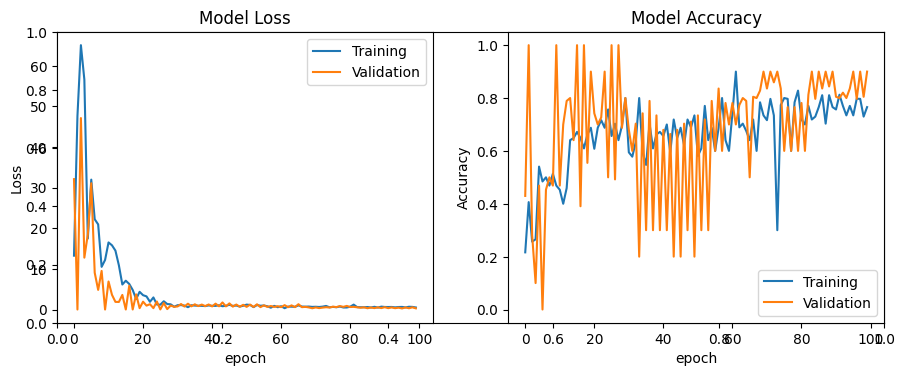

In [ ]:
print("Trained on", MODEL)
print("The Model Accuracy for Train data is: ", "{:.2%}".format(Training_Accuracy[1]))
print("The Model Accuracy for Validation data is: ", "{:.2%}".format(Validation_Accuracy[1]))
print("FINAL VALIDATION ACCURACY MEAN-5: ", np.mean(final_accuracy))
# Loss and Accuracy
plt.subplots(figsize=(9,3.5))
plt.tight_layout()
display_training_curves(history.history['loss'], history.history['val_loss'], 'Loss', 121)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy', 122)

In [ ]:
model.save('/content/drive/MyDrive/PCGIPI/savedmodels/InceptionV3.h5')

In [19]:
IMAGE_CLASSES = ['Normal','Grade I','Grade II','Grade III']         # Naming Classes (The names must be in the same order as in dataset folder (usually alphabetically))
MODEL = 'InceptionResNetV2'           # ["Xception", "VGG16", "VGG19", "ResNet50V2", "ResNet101V2", "ResNet152V2", "InceptionV3", "InceptionResNetV2", "MobileNetV2", "DenseNet121", "DenseNet169", "DenseNet201", "NASNetMobile", "NASNetLarge"]         # Name of the model to save after training
BATCH_SIZE = 64  # {type: "int"}# Mini-batch size
SEED = 2020                     # Fixed randomness For reproducible result
EPOCH = 100                     #  {type: "int"}Epoch
python_random.seed(SEED)        # necessary for starting core Python generated random numbers in a well-defined state.
np.random.seed(SEED)            # necessary for starting Numpy generated random numbers in a well-defined state.
tf.random.set_seed(SEED)        # will make random number generation in the TensorFlow backend have a well-defined initial state.

IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL = get_pretrained_model_input_size(MODEL)
print("Training on", MODEL)
print("Input:",IMAGE_WIDTH,'x',IMAGE_HEIGHT,'x',IMAGE_CHANNEL)

Training on InceptionResNetV2
Input: 299 x 299 x 3


In [20]:
train_generator = get_train_generator()
valid_generator = get_valid_generator()
test_generator = get_test_generator()
# Check number of image in each class
train_freq = get_freq_data(train_generator)
valid_freq = get_freq_data(valid_generator)
total_freq = np.array(train_freq) + np.array(valid_freq)
valid_data_freq = np.array(valid_freq)/total_freq
print("Valid data Percentage:",valid_data_freq)

Getting train generator...
Found 3201 images belonging to 4 classes.
Getting valid generator...
Found 138 images belonging to 4 classes.
Getting test generator...
Found 138 images belonging to 4 classes.
Total number of class is: 4 {'0Normal': 0, '1Grade I': 1, '2Grade II': 2, '3Grade III': 3}
Total image in generator is:  [540, 714, 1292, 655]
Total number of class is: 4 {'0Normal': 0, '1Grade I': 1, '2Grade II': 2, '3Grade III': 3}
Total image in generator is:  [20, 31, 58, 29]
Valid data Percentage: [0.03571429 0.04161074 0.04296296 0.04239766]


In [ ]:
model = get_pretrained_model(MODEL, weights = 'imagenet', unfreeze_last_layer = 0, print_summary = False, print_fine_tuning_summary = True)

InceptionResNetV2 pre-trained model selected
219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
###################### AFTER FINE TUNING ########################


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_resnet_v2 (Functional)     │ (None, 8, 8, 1536)          │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 98304)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │      25,166,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,503,844 (303.28 MB)

 Trainable params: 25,167,108 (96.00 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

InceptionResNetV2 pre-trained model selected


In [ ]:
time_start = time.time()
history = model.fit(
    x = train_generator,
    validation_data = valid_generator,
    epochs = EPOCH,
    verbose = 1,
    steps_per_epoch = train_generator.samples // train_generator.batch_size ,
    validation_steps = valid_generator.samples // valid_generator.batch_size
)
print("Training done. Evaluating...")
time_end = time.time()
final_accuracy = history.history["val_accuracy"][-5:]
Training_Accuracy = model.evaluate(train_generator, steps=train_generator.samples // train_generator.batch_size)
Validation_Accuracy = model.evaluate(test_generator, steps=valid_generator.samples // valid_generator.batch_size)
print("Finish!")

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 65s 25s/step - accuracy: 0.2635 - loss: 2.9719 - val_accuracy: 0.1484 - val_loss: 60.8289
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 6s/step - accuracy: 0.2031 - loss: 56.6370 - val_accuracy: 0.5000 - val_loss: 1.4168
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.4740 - loss: 18.8187 - val_accuracy: 0.5703 - val_loss: 8.8734
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.3000 - loss: 25.5621 - val_accuracy: 0.0000e+00 - val_loss: 39.8094
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.4289 - loss: 22.5868 - val_accuracy: 0.4375 - val_loss: 5.7591
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.5469 - loss: 11.3680 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.5246 - loss: 11.0615 - val_accuracy: 0.2344 - val_loss: 14.6047
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step - accuracy: 0.4844 - loss: 12.9123 - val_accuracy: 1.00

Trained on InceptionResNetV2
The Model Accuracy for Train data is:  89.06%
The Model Accuracy for Validation data is:  79.69%
FINAL VALIDATION ACCURACY MEAN-5:  0.7387499928474426


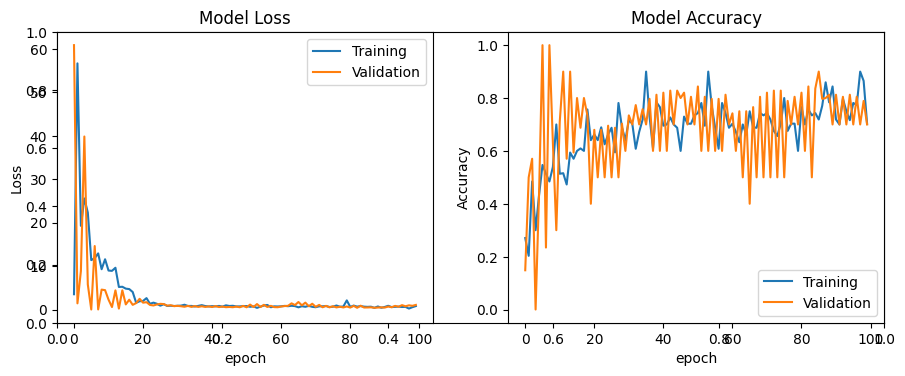

In [ ]:
print("Trained on", MODEL)
print("The Model Accuracy for Train data is: ", "{:.2%}".format(Training_Accuracy[1]))
print("The Model Accuracy for Validation data is: ", "{:.2%}".format(Validation_Accuracy[1]))
print("FINAL VALIDATION ACCURACY MEAN-5: ", np.mean(final_accuracy))
# Loss and Accuracy
plt.subplots(figsize=(9,3.5))
plt.tight_layout()
display_training_curves(history.history['loss'], history.history['val_loss'], 'Loss', 121)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy', 122)

In [ ]:
model.save('/content/drive/MyDrive/PCGIPI/savedmodels/InceptionResNetV2.h5')

In [21]:
IMAGE_CLASSES = ['Normal','Grade I','Grade II','Grade III']         # Naming Classes (The names must be in the same order as in dataset folder (usually alphabetically))
MODEL = 'MobileNetV2'           # ["Xception", "VGG16", "VGG19", "ResNet50V2", "ResNet101V2", "ResNet152V2", "InceptionV3", "InceptionResNetV2", "MobileNetV2", "DenseNet121", "DenseNet169", "DenseNet201", "NASNetMobile", "NASNetLarge"]         # Name of the model to save after training
BATCH_SIZE = 64  # {type: "int"}# Mini-batch size
SEED = 2020                     # Fixed randomness For reproducible result
EPOCH = 100                     #  {type: "int"}Epoch
python_random.seed(SEED)        # necessary for starting core Python generated random numbers in a well-defined state.
np.random.seed(SEED)            # necessary for starting Numpy generated random numbers in a well-defined state.
tf.random.set_seed(SEED)        # will make random number generation in the TensorFlow backend have a well-defined initial state.

IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL = get_pretrained_model_input_size(MODEL)
print("Training on", MODEL)
print("Input:",IMAGE_WIDTH,'x',IMAGE_HEIGHT,'x',IMAGE_CHANNEL)

Training on MobileNetV2
Input: 224 x 224 x 3


In [22]:
train_generator = get_train_generator()
valid_generator = get_valid_generator()
test_generator = get_test_generator()
# Check number of image in each class
train_freq = get_freq_data(train_generator)
valid_freq = get_freq_data(valid_generator)
total_freq = np.array(train_freq) + np.array(valid_freq)
valid_data_freq = np.array(valid_freq)/total_freq
print("Valid data Percentage:",valid_data_freq)

Getting train generator...
Found 3201 images belonging to 4 classes.
Getting valid generator...
Found 138 images belonging to 4 classes.
Getting test generator...
Found 138 images belonging to 4 classes.
Total number of class is: 4 {'0Normal': 0, '1Grade I': 1, '2Grade II': 2, '3Grade III': 3}
Total image in generator is:  [540, 714, 1292, 655]
Total number of class is: 4 {'0Normal': 0, '1Grade I': 1, '2Grade II': 2, '3Grade III': 3}
Total image in generator is:  [20, 31, 58, 29]
Valid data Percentage: [0.03571429 0.04161074 0.04296296 0.04239766]


In [ ]:
model = get_pretrained_model(MODEL, weights = 'imagenet', unfreeze_last_layer = 0, print_summary = False, print_fine_tuning_summary = True)

MobileNetV2 pre-trained model selected
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
###################### AFTER FINE TUNING ########################


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 256)                 │      16,056,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,315,588 (69.87 MB)

 Trainable params: 16,057,604 (61.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

MobileNetV2 pre-trained model selected


In [ ]:
time_start = time.time()
history = model.fit(
    x = train_generator,
    validation_data = valid_generator,
    epochs = EPOCH,
    verbose = 1,
    steps_per_epoch = train_generator.samples // train_generator.batch_size ,
    validation_steps = valid_generator.samples // valid_generator.batch_size
)
print("Training done. Evaluating...")
time_end = time.time()
final_accuracy = history.history["val_accuracy"][-5:]
Training_Accuracy = model.evaluate(train_generator, steps=train_generator.samples // train_generator.batch_size)
Validation_Accuracy = model.evaluate(test_generator, steps=valid_generator.samples // valid_generator.batch_size)
print("Finish!")

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - accuracy: 0.2969 - loss: 16.6938 - val_accuracy: 0.1562 - val_loss: 47.2879
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.1000 - loss: 48.5579 - val_accuracy: 1.0000 - val_loss: 3.5763e-08
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 848ms/step - accuracy: 0.3294 - loss: 19.0270 - val_accuracy: 0.4062 - val_loss: 6.4701
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.5625 - loss: 7.1483 - val_accuracy: 0.7000 - val_loss: 1.9932
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 716ms/step - accuracy: 0.5260 - loss: 8.6060 - val_accuracy: 0.6094 - val_loss: 3.4665
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5000 - loss: 8.0716 - val_accuracy: 0.6000 - val_loss: 2.2696
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 697ms/step - accuracy: 0.5833 - loss: 7.6395 - val_accuracy: 0.6328 - val_loss: 3.4324
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3000 - loss: 12.6116 - val_accuracy: 0.7000 

Trained on MobileNetV2
The Model Accuracy for Train data is:  89.06%
The Model Accuracy for Validation data is:  91.41%
FINAL VALIDATION ACCURACY MEAN-5:  0.8146875023841857


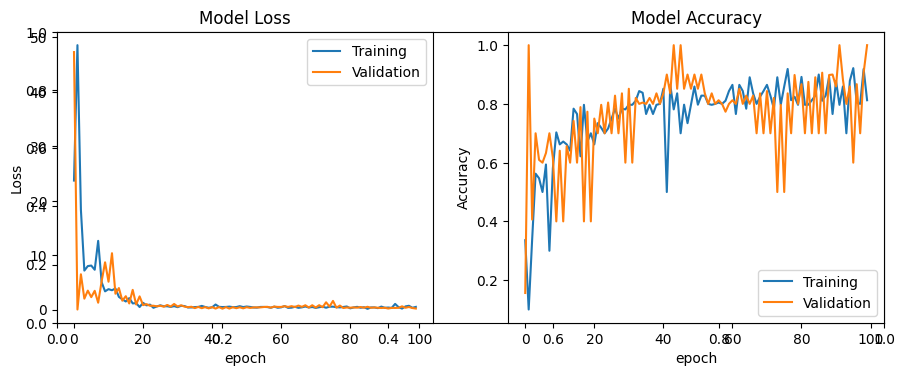

In [ ]:
print("Trained on", MODEL)
print("The Model Accuracy for Train data is: ", "{:.2%}".format(Training_Accuracy[1]))
print("The Model Accuracy for Validation data is: ", "{:.2%}".format(Validation_Accuracy[1]))
print("FINAL VALIDATION ACCURACY MEAN-5: ", np.mean(final_accuracy))
# Loss and Accuracy
plt.subplots(figsize=(9,3.5))
plt.tight_layout()
display_training_curves(history.history['loss'], history.history['val_loss'], 'Loss', 121)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy', 122)

In [ ]:
model.save('/content/drive/MyDrive/PCGIPI/savedmodels/MobileNetV2.h5')

In [23]:
IMAGE_CLASSES = ['Normal','Grade I','Grade II','Grade III']         # Naming Classes (The names must be in the same order as in dataset folder (usually alphabetically))
MODEL = 'DenseNet121'           # ["Xception", "VGG16", "VGG19", "ResNet50V2", "ResNet101V2", "ResNet152V2", "InceptionV3", "InceptionResNetV2", "MobileNetV2", "DenseNet121", "DenseNet169", "DenseNet201", "NASNetMobile", "NASNetLarge"]         # Name of the model to save after training
BATCH_SIZE = 64  # {type: "int"}# Mini-batch size
SEED = 2020                     # Fixed randomness For reproducible result
EPOCH = 100                     #  {type: "int"}Epoch
python_random.seed(SEED)        # necessary for starting core Python generated random numbers in a well-defined state.
np.random.seed(SEED)            # necessary for starting Numpy generated random numbers in a well-defined state.
tf.random.set_seed(SEED)        # will make random number generation in the TensorFlow backend have a well-defined initial state.

IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL = get_pretrained_model_input_size(MODEL)
print("Training on", MODEL)
print("Input:",IMAGE_WIDTH,'x',IMAGE_HEIGHT,'x',IMAGE_CHANNEL)

Training on DenseNet121
Input: 224 x 224 x 3


In [24]:
train_generator = get_train_generator()
valid_generator = get_valid_generator()
test_generator = get_test_generator()
# Check number of image in each class
train_freq = get_freq_data(train_generator)
valid_freq = get_freq_data(valid_generator)
total_freq = np.array(train_freq) + np.array(valid_freq)
valid_data_freq = np.array(valid_freq)/total_freq
print("Valid data Percentage:",valid_data_freq)

Getting train generator...
Found 3201 images belonging to 4 classes.
Getting valid generator...
Found 138 images belonging to 4 classes.
Getting test generator...
Found 138 images belonging to 4 classes.
Total number of class is: 4 {'0Normal': 0, '1Grade I': 1, '2Grade II': 2, '3Grade III': 3}
Total image in generator is:  [540, 714, 1292, 655]
Total number of class is: 4 {'0Normal': 0, '1Grade I': 1, '2Grade II': 2, '3Grade III': 3}
Total image in generator is:  [20, 31, 58, 29]
Valid data Percentage: [0.03571429 0.04161074 0.04296296 0.04239766]


In [ ]:
model = get_pretrained_model(MODEL, weights = 'imagenet', unfreeze_last_layer = 0, print_summary = False, print_fine_tuning_summary = True)

DenseNet121 pre-trained model selected
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
###################### AFTER FINE TUNING ########################


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 256)                 │      12,845,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,883,844 (75.85 MB)

 Trainable params: 12,846,340 (49.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

DenseNet121 pre-trained model selected


In [ ]:
time_start = time.time()
history = model.fit(
    x = train_generator,
    validation_data = valid_generator,
    epochs = EPOCH,
    verbose = 1,
    steps_per_epoch = train_generator.samples // train_generator.batch_size ,
    validation_steps = valid_generator.samples // valid_generator.batch_size
)
print("Training done. Evaluating...")
time_end = time.time()
final_accuracy = history.history["val_accuracy"][-5:]
Training_Accuracy = model.evaluate(train_generator, steps=train_generator.samples // train_generator.batch_size)
Validation_Accuracy = model.evaluate(test_generator, steps=valid_generator.samples // valid_generator.batch_size)
print("Finish!")

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 43s 18s/step - accuracy: 0.4640 - loss: 7.3301 - val_accuracy: 0.2578 - val_loss: 21.7170
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.2812 - loss: 26.2124 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 903ms/step - accuracy: 0.3594 - loss: 14.5894 - val_accuracy: 0.4844 - val_loss: 6.0731
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5000 - loss: 10.6556 - val_accuracy: 0.6000 - val_loss: 4.0007
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 742ms/step - accuracy: 0.4199 - loss: 14.3105 - val_accuracy: 0.2031 - val_loss: 16.6680
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 428ms/step - accuracy: 0.5156 - loss: 13.1431 - val_accuracy: 1.0000 - val_loss: 9.1791e-07
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 820ms/step - accuracy: 0.4109 - loss: 15.2913 - val_accuracy: 0.3672 - val_loss: 10.9707
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.4844 - loss: 14.6192 - val_accuracy: 0.

Trained on DenseNet121
The Model Accuracy for Train data is:  90.62%
The Model Accuracy for Validation data is:  84.38%
FINAL VALIDATION ACCURACY MEAN-5:  0.9359375


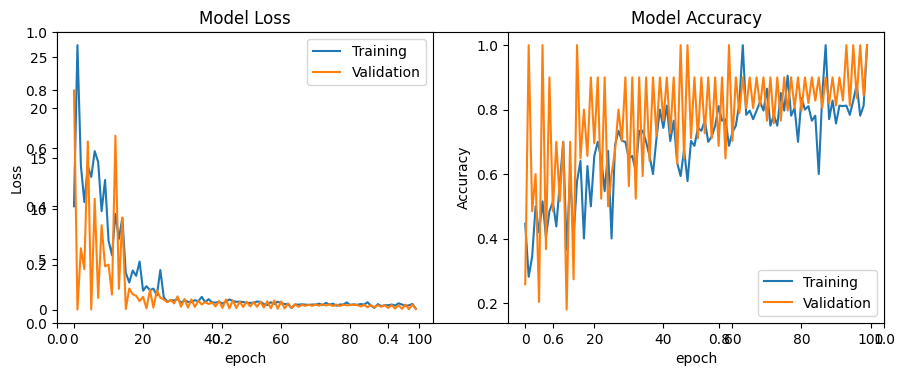

In [ ]:
print("Trained on", MODEL)
print("The Model Accuracy for Train data is: ", "{:.2%}".format(Training_Accuracy[1]))
print("The Model Accuracy for Validation data is: ", "{:.2%}".format(Validation_Accuracy[1]))
print("FINAL VALIDATION ACCURACY MEAN-5: ", np.mean(final_accuracy))
# Loss and Accuracy
plt.subplots(figsize=(9,3.5))
plt.tight_layout()
display_training_curves(history.history['loss'], history.history['val_loss'], 'Loss', 121)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy', 122)

In [ ]:
model.save('/content/drive/MyDrive/PCGIPI/savedmodels/DenseNet121.h5')

In [25]:
IMAGE_CLASSES = ['Normal','Grade I','Grade II','Grade III']         # Naming Classes (The names must be in the same order as in dataset folder (usually alphabetically))
MODEL = 'DenseNet169'           # ["Xception", "VGG16", "VGG19", "ResNet50V2", "ResNet101V2", "ResNet152V2", "InceptionV3", "InceptionResNetV2", "MobileNetV2", "DenseNet121", "DenseNet169", "DenseNet201", "NASNetMobile", "NASNetLarge"]         # Name of the model to save after training
BATCH_SIZE = 64  # {type: "int"}# Mini-batch size
SEED = 2020                     # Fixed randomness For reproducible result
EPOCH = 100                     #  {type: "int"}Epoch
python_random.seed(SEED)        # necessary for starting core Python generated random numbers in a well-defined state.
np.random.seed(SEED)            # necessary for starting Numpy generated random numbers in a well-defined state.
tf.random.set_seed(SEED)        # will make random number generation in the TensorFlow backend have a well-defined initial state.

IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL = get_pretrained_model_input_size(MODEL)
print("Training on", MODEL)
print("Input:",IMAGE_WIDTH,'x',IMAGE_HEIGHT,'x',IMAGE_CHANNEL)

Training on DenseNet169
Input: 224 x 224 x 3


In [26]:
train_generator = get_train_generator()
valid_generator = get_valid_generator()
test_generator = get_test_generator()
# Check number of image in each class
train_freq = get_freq_data(train_generator)
valid_freq = get_freq_data(valid_generator)
total_freq = np.array(train_freq) + np.array(valid_freq)
valid_data_freq = np.array(valid_freq)/total_freq
print("Valid data Percentage:",valid_data_freq)

Getting train generator...
Found 3201 images belonging to 4 classes.
Getting valid generator...
Found 138 images belonging to 4 classes.
Getting test generator...
Found 138 images belonging to 4 classes.
Total number of class is: 4 {'0Normal': 0, '1Grade I': 1, '2Grade II': 2, '3Grade III': 3}
Total image in generator is:  [540, 714, 1292, 655]
Total number of class is: 4 {'0Normal': 0, '1Grade I': 1, '2Grade II': 2, '3Grade III': 3}
Total image in generator is:  [20, 31, 58, 29]
Valid data Percentage: [0.03571429 0.04161074 0.04296296 0.04239766]


In [ ]:
model = get_pretrained_model(MODEL, weights = 'imagenet', unfreeze_last_layer = 0, print_summary = False, print_fine_tuning_summary = True)

DenseNet169 pre-trained model selected
51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
###################### AFTER FINE TUNING ########################


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet169 (Functional)             │ (None, 7, 7, 1664)          │      12,642,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 81536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      20,873,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,517,380 (127.86 MB)

 Trainable params: 20,874,500 (79.63 MB)

 Non-trainable params: 12,642,880 (48.23 MB)

DenseNet169 pre-trained model selected


In [ ]:
time_start = time.time()
history = model.fit(
    x = train_generator,
    validation_data = valid_generator,
    epochs = EPOCH,
    verbose = 1,
    steps_per_epoch = train_generator.samples // train_generator.batch_size ,
    validation_steps = valid_generator.samples // valid_generator.batch_size
)
print("Training done. Evaluating...")
time_end = time.time()
final_accuracy = history.history["val_accuracy"][-5:]
Training_Accuracy = model.evaluate(train_generator, steps=train_generator.samples // train_generator.batch_size)
Validation_Accuracy = model.evaluate(test_generator, steps=valid_generator.samples // valid_generator.batch_size)
print("Finish!")

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7881 - loss: 0.5617 - val_accuracy: 0.8984 - val_loss: 0.2760
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8906 - loss: 0.2558 - val_accuracy: 0.9000 - val_loss: 0.3854
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7812 - loss: 0.4632 - val_accuracy: 0.8984 - val_loss: 0.2729
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.9000 - loss: 0.1204 - val_accuracy: 1.0000 - val_loss: 0.2998
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7892 - loss: 0.4773 - val_accuracy: 0.8906 - val_loss: 0.2926
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.8281 - loss: 0.4643 - val_accuracy: 1.0000 - val_loss: 0.1815
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 848ms/step - accuracy: 0.8114 - loss: 0.4609 - val_accuracy: 0.8984 - val_loss: 0.2718
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8594 - loss: 0.2970 - val_accuracy: 1.0000 - val_loss: 0

Trained on DenseNet201
The Model Accuracy for Train data is:  89.06%
The Model Accuracy for Validation data is:  85.94%
FINAL VALIDATION ACCURACY MEAN-5:  0.7453125


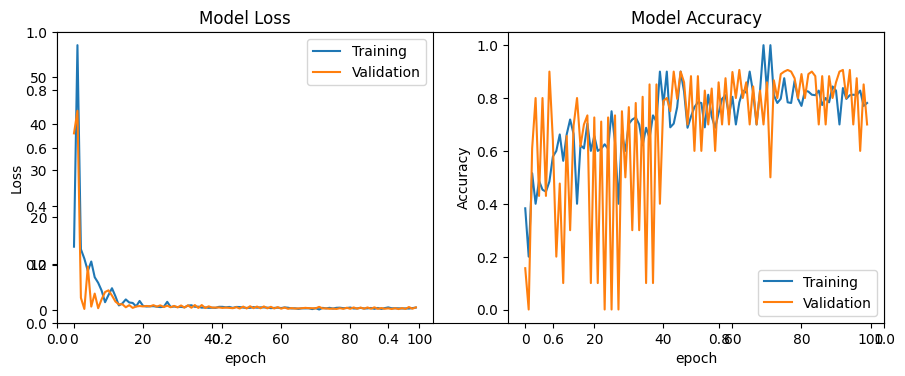

In [ ]:
print("Trained on", MODEL)
print("The Model Accuracy for Train data is: ", "{:.2%}".format(Training_Accuracy[1]))
print("The Model Accuracy for Validation data is: ", "{:.2%}".format(Validation_Accuracy[1]))
print("FINAL VALIDATION ACCURACY MEAN-5: ", np.mean(final_accuracy))
# Loss and Accuracy
plt.subplots(figsize=(9,3.5))
plt.tight_layout()
display_training_curves(history.history['loss'], history.history['val_loss'], 'Loss', 121)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy', 122)

In [ ]:
model.save('/content/drive/MyDrive/PCGIPI/savedmodels/DenseNet169.h5')

In [27]:
IMAGE_CLASSES = ['Normal','Grade I','Grade II','Grade III']         # Naming Classes (The names must be in the same order as in dataset folder (usually alphabetically))
MODEL = 'NASNetMobile'           # ["Xception", "VGG16", "VGG19", "ResNet50V2", "ResNet101V2", "ResNet152V2", "InceptionV3", "InceptionResNetV2", "MobileNetV2", "DenseNet121", "DenseNet169", "DenseNet201", "NASNetMobile", "NASNetLarge"]         # Name of the model to save after training
BATCH_SIZE = 64  # {type: "int"}# Mini-batch size
SEED = 2020                     # Fixed randomness For reproducible result
EPOCH = 100                     #  {type: "int"}Epoch
python_random.seed(SEED)        # necessary for starting core Python generated random numbers in a well-defined state.
np.random.seed(SEED)            # necessary for starting Numpy generated random numbers in a well-defined state.
tf.random.set_seed(SEED)        # will make random number generation in the TensorFlow backend have a well-defined initial state.

IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL = get_pretrained_model_input_size(MODEL)
print("Training on", MODEL)
print("Input:",IMAGE_WIDTH,'x',IMAGE_HEIGHT,'x',IMAGE_CHANNEL)

Training on NASNetMobile
Input: 224 x 224 x 3


In [28]:
train_generator = get_train_generator()
valid_generator = get_valid_generator()
test_generator = get_test_generator()
# Check number of image in each class
train_freq = get_freq_data(train_generator)
valid_freq = get_freq_data(valid_generator)
total_freq = np.array(train_freq) + np.array(valid_freq)
valid_data_freq = np.array(valid_freq)/total_freq
print("Valid data Percentage:",valid_data_freq)

Getting train generator...
Found 3201 images belonging to 4 classes.
Getting valid generator...
Found 138 images belonging to 4 classes.
Getting test generator...
Found 138 images belonging to 4 classes.
Total number of class is: 4 {'0Normal': 0, '1Grade I': 1, '2Grade II': 2, '3Grade III': 3}
Total image in generator is:  [540, 714, 1292, 655]
Total number of class is: 4 {'0Normal': 0, '1Grade I': 1, '2Grade II': 2, '3Grade III': 3}
Total image in generator is:  [20, 31, 58, 29]
Valid data Percentage: [0.03571429 0.04161074 0.04296296 0.04239766]


In [ ]:
model = get_pretrained_model(MODEL, weights = 'imagenet', unfreeze_last_layer = 0, print_summary = False, print_fine_tuning_summary = True)

NASNetMobile pre-trained model selected
19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
###################### AFTER FINE TUNING ########################


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ nasnet_mobile (Functional)           │ (None, 7, 7, 1056)          │       4,269,716 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 51744)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      13,246,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,517,464 (66.82 MB)

 Trainable params: 13,247,748 (50.54 MB)

 Non-trainable params: 4,269,716 (16.29 MB)

NASNetMobile pre-trained model selected


In [ ]:
time_start = time.time()
history = model.fit(
    x = train_generator,
    validation_data = valid_generator,
    epochs = EPOCH,
    verbose = 1,
    steps_per_epoch = train_generator.samples // train_generator.batch_size ,
    validation_steps = valid_generator.samples // valid_generator.batch_size
)
print("Training done. Evaluating...")
time_end = time.time()
final_accuracy = history.history["val_accuracy"][-5:]
Training_Accuracy = model.evaluate(train_generator, steps=train_generator.samples // train_generator.batch_size)
Validation_Accuracy = model.evaluate(test_generator, steps=valid_generator.samples // valid_generator.batch_size)
print("Finish!")

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 62s 24s/step - accuracy: 0.2919 - loss: 4.8861 - val_accuracy: 0.1484 - val_loss: 55.3988
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.1875 - loss: 55.5791 - val_accuracy: 0.8000 - val_loss: 0.7762
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 37s 971ms/step - accuracy: 0.4062 - loss: 29.1052 - val_accuracy: 0.4453 - val_loss: 13.3322
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4000 - loss: 21.1762 - val_accuracy: 0.0000e+00 - val_loss: 14.2627
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 716ms/step - accuracy: 0.4820 - loss: 12.9378 - val_accuracy: 0.3750 - val_loss: 5.7381
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.3594 - loss: 11.9973 - val_accuracy: 0.9000 - val_loss: 1.6189
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 823ms/step - accuracy: 0.3162 - loss: 13.7271 - val_accuracy: 0.3359 - val_loss: 6.1834
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 491ms/step - accuracy: 0.5625 - loss: 5.8457 - val_accuracy: 0.

Trained on NASNetMobile
The Model Accuracy for Train data is:  87.50%
The Model Accuracy for Validation data is:  71.09%
FINAL VALIDATION ACCURACY MEAN-5:  0.8506250023841858


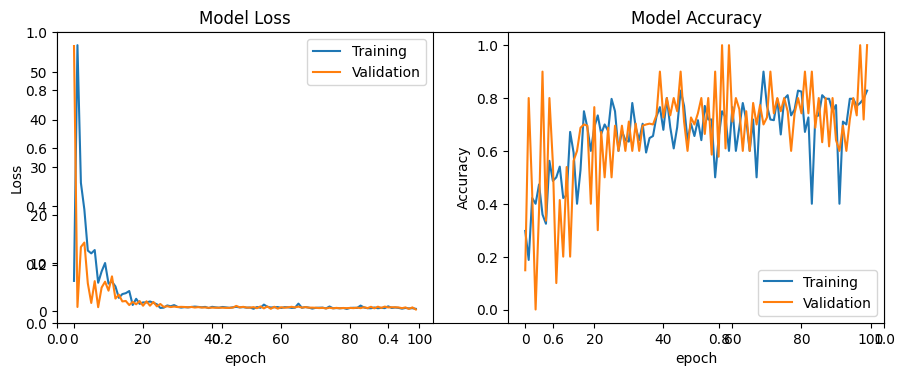

In [ ]:
print("Trained on", MODEL)
print("The Model Accuracy for Train data is: ", "{:.2%}".format(Training_Accuracy[1]))
print("The Model Accuracy for Validation data is: ", "{:.2%}".format(Validation_Accuracy[1]))
print("FINAL VALIDATION ACCURACY MEAN-5: ", np.mean(final_accuracy))
# Loss and Accuracy
plt.subplots(figsize=(9,3.5))
plt.tight_layout()
display_training_curves(history.history['loss'], history.history['val_loss'], 'Loss', 121)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy', 122)

In [ ]:
model.save('/content/drive/MyDrive/PCGIPI/savedmodels/NASNetMobile.h5')

In [29]:
IMAGE_CLASSES = ['Normal','Grade I','Grade II','Grade III']         # Naming Classes (The names must be in the same order as in dataset folder (usually alphabetically))
MODEL = 'NASNetLarge'           # ["Xception", "VGG16", "VGG19", "ResNet50V2", "ResNet101V2", "ResNet152V2", "InceptionV3", "InceptionResNetV2", "MobileNetV2", "DenseNet121", "DenseNet169", "DenseNet201", "NASNetMobile", "NASNetLarge"]         # Name of the model to save after training
BATCH_SIZE = 64  # {type: "int"}# Mini-batch size
SEED = 2020                     # Fixed randomness For reproducible result
EPOCH = 100                     #  {type: "int"}Epoch
python_random.seed(SEED)        # necessary for starting core Python generated random numbers in a well-defined state.
np.random.seed(SEED)            # necessary for starting Numpy generated random numbers in a well-defined state.
tf.random.set_seed(SEED)        # will make random number generation in the TensorFlow backend have a well-defined initial state.

IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL = get_pretrained_model_input_size(MODEL)
print("Training on", MODEL)
print("Input:",IMAGE_WIDTH,'x',IMAGE_HEIGHT,'x',IMAGE_CHANNEL)

Training on NASNetLarge
Input: 331 x 331 x 3


In [30]:
train_generator = get_train_generator()
valid_generator = get_valid_generator()
test_generator = get_test_generator()
# Check number of image in each class
train_freq = get_freq_data(train_generator)
valid_freq = get_freq_data(valid_generator)
total_freq = np.array(train_freq) + np.array(valid_freq)
valid_data_freq = np.array(valid_freq)/total_freq
print("Valid data Percentage:",valid_data_freq)

Getting train generator...
Found 3201 images belonging to 4 classes.
Getting valid generator...
Found 138 images belonging to 4 classes.
Getting test generator...
Found 138 images belonging to 4 classes.
Total number of class is: 4 {'0Normal': 0, '1Grade I': 1, '2Grade II': 2, '3Grade III': 3}
Total image in generator is:  [540, 714, 1292, 655]
Total number of class is: 4 {'0Normal': 0, '1Grade I': 1, '2Grade II': 2, '3Grade III': 3}
Total image in generator is:  [20, 31, 58, 29]
Valid data Percentage: [0.03571429 0.04161074 0.04296296 0.04239766]


In [ ]:
model = get_pretrained_model(MODEL, weights = 'imagenet', unfreeze_last_layer = 0, print_summary = False, print_fine_tuning_summary = True)

NASNetLarge pre-trained model selected
343610240/343610240 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
###################### AFTER FINE TUNING ########################


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ nasnet_large (Functional)            │ (None, 11, 11, 4032)        │      84,916,818 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 487872)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │     124,895,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 209,813,334 (800.37 MB)

 Trainable params: 124,896,516 (476.44 MB)

 Non-trainable params: 84,916,818 (323.93 MB)

NASNetLarge pre-trained model selected


In [ ]:
time_start = time.time()
history = model.fit(
    x = train_generator,
    validation_data = valid_generator,
    epochs = EPOCH,
    verbose = 1,
    steps_per_epoch = train_generator.samples // train_generator.batch_size ,
    validation_steps = valid_generator.samples // valid_generator.batch_size
)
print("Training done. Evaluating...")
time_end = time.time()
final_accuracy = history.history["val_accuracy"][-5:]
Training_Accuracy = model.evaluate(train_generator, steps=train_generator.samples // train_generator.batch_size)
Validation_Accuracy = model.evaluate(test_generator, steps=valid_generator.samples // valid_generator.batch_size)
print("Finish!")

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 108s 22s/step - accuracy: 0.2760 - loss: 33.9552 - val_accuracy: 0.2500 - val_loss: 39.0961
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 31s 8s/step - accuracy: 0.3000 - loss: 69.5170 - val_accuracy: 0.6000 - val_loss: 3.6114
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 5s/step - accuracy: 0.3542 - loss: 41.1760 - val_accuracy: 0.5312 - val_loss: 10.6306
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - accuracy: 0.4000 - loss: 13.6172 - val_accuracy: 0.4000 - val_loss: 15.9075
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step - accuracy: 0.5781 - loss: 18.3914 - val_accuracy: 0.4688 - val_loss: 11.8462
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - accuracy: 0.5000 - loss: 18.7917 - val_accuracy: 0.0000e+00 - val_loss: 41.0475
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.5027 - loss: 19.8600 - val_accuracy: 0.3828 - val_loss: 15.9172
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 293ms/step - accuracy: 0.5781 - loss: 10.7163 - val_accuracy: 0

Trained on NASNetLarge
The Model Accuracy for Train data is:  89.06%
The Model Accuracy for Validation data is:  78.91%
FINAL VALIDATION ACCURACY MEAN-5:  0.7324999928474426


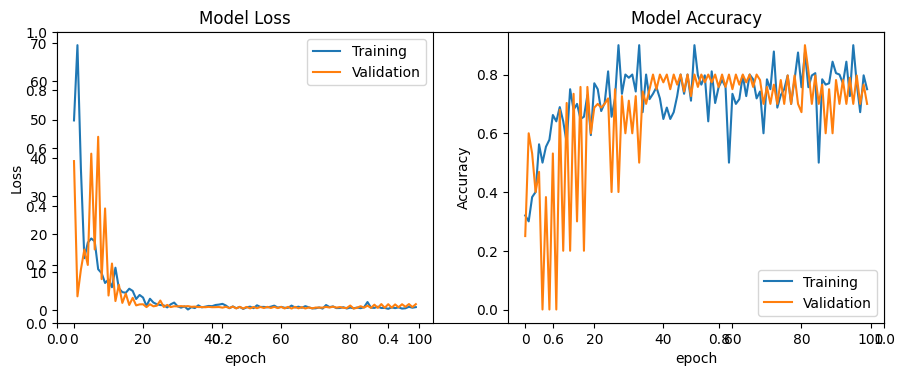

In [ ]:
print("Trained on", MODEL)
print("The Model Accuracy for Train data is: ", "{:.2%}".format(Training_Accuracy[1]))
print("The Model Accuracy for Validation data is: ", "{:.2%}".format(Validation_Accuracy[1]))
print("FINAL VALIDATION ACCURACY MEAN-5: ", np.mean(final_accuracy))
# Loss and Accuracy
plt.subplots(figsize=(9,3.5))
plt.tight_layout()
display_training_curves(history.history['loss'], history.history['val_loss'], 'Loss', 121)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy', 122)

In [ ]:
model.save('/content/drive/MyDrive/PCGIPI/savedmodels/NASNetLarge.h5')